In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "fsv4"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 287
Categorical features: 6
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 359
Categorical Columns: 6


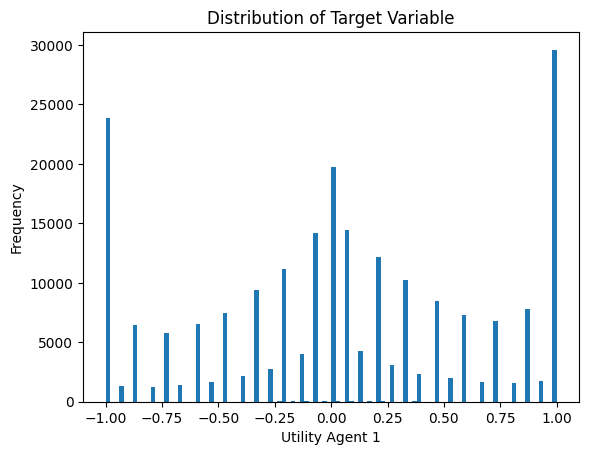

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.494455


[200]	valid_0's rmse: 0.476845


[300]	valid_0's rmse: 0.467619


[400]	valid_0's rmse: 0.461289


[500]	valid_0's rmse: 0.457175


[600]	valid_0's rmse: 0.453316


[700]	valid_0's rmse: 0.450664


[800]	valid_0's rmse: 0.44824


[900]	valid_0's rmse: 0.445565


[1000]	valid_0's rmse: 0.443559


[1100]	valid_0's rmse: 0.441957


[1200]	valid_0's rmse: 0.440612


[1300]	valid_0's rmse: 0.439676


[1400]	valid_0's rmse: 0.43872


[1500]	valid_0's rmse: 0.43776


[1600]	valid_0's rmse: 0.437118


[1700]	valid_0's rmse: 0.436505


[1800]	valid_0's rmse: 0.435942


[1900]	valid_0's rmse: 0.435353


[2000]	valid_0's rmse: 0.434872


[2100]	valid_0's rmse: 0.434354


[2200]	valid_0's rmse: 0.43383


[2300]	valid_0's rmse: 0.433356


[2400]	valid_0's rmse: 0.433017


[2500]	valid_0's rmse: 0.432617


[2600]	valid_0's rmse: 0.432261


[2700]	valid_0's rmse: 0.43189


[2800]	valid_0's rmse: 0.431687


[2900]	valid_0's rmse: 0.431363


[3000]	valid_0's rmse: 0.431121


[3100]	valid_0's rmse: 0.430854


[3200]	valid_0's rmse: 0.43068


[3300]	valid_0's rmse: 0.430524


[3400]	valid_0's rmse: 0.430228


[3500]	valid_0's rmse: 0.429986


[3600]	valid_0's rmse: 0.429866


[3700]	valid_0's rmse: 0.429727


[3800]	valid_0's rmse: 0.42961


[3900]	valid_0's rmse: 0.429487


[4000]	valid_0's rmse: 0.429338


[4100]	valid_0's rmse: 0.429178


[4200]	valid_0's rmse: 0.429057


[4300]	valid_0's rmse: 0.428961


[4400]	valid_0's rmse: 0.428891


[4500]	valid_0's rmse: 0.428769


[4600]	valid_0's rmse: 0.428669


[4700]	valid_0's rmse: 0.428535


[4800]	valid_0's rmse: 0.428359


[4900]	valid_0's rmse: 0.428262


[5000]	valid_0's rmse: 0.428169


[5100]	valid_0's rmse: 0.428096


[5200]	valid_0's rmse: 0.428042


[5300]	valid_0's rmse: 0.427913


[5400]	valid_0's rmse: 0.427802


[5500]	valid_0's rmse: 0.427723


[5600]	valid_0's rmse: 0.427642


[5700]	valid_0's rmse: 0.427613


[5800]	valid_0's rmse: 0.427497


[5900]	valid_0's rmse: 0.427477


[6000]	valid_0's rmse: 0.427392


[6100]	valid_0's rmse: 0.427285


[6200]	valid_0's rmse: 0.427338


[6300]	valid_0's rmse: 0.427304


[6400]	valid_0's rmse: 0.427278


[6500]	valid_0's rmse: 0.427176


[6600]	valid_0's rmse: 0.42716


[6700]	valid_0's rmse: 0.427072


[6800]	valid_0's rmse: 0.426983


[6900]	valid_0's rmse: 0.426977


[7000]	valid_0's rmse: 0.426911


[7100]	valid_0's rmse: 0.426878


[7200]	valid_0's rmse: 0.426855


[7300]	valid_0's rmse: 0.426753


[7400]	valid_0's rmse: 0.426683


[7500]	valid_0's rmse: 0.426632


[7600]	valid_0's rmse: 0.426642


[7700]	valid_0's rmse: 0.426603


[7800]	valid_0's rmse: 0.426579


[7900]	valid_0's rmse: 0.426539


[8000]	valid_0's rmse: 0.426488


[8100]	valid_0's rmse: 0.426498


[8200]	valid_0's rmse: 0.426488


[8300]	valid_0's rmse: 0.42645


[8400]	valid_0's rmse: 0.426446


[8500]	valid_0's rmse: 0.426405


[8600]	valid_0's rmse: 0.426363


[8700]	valid_0's rmse: 0.426359


[8800]	valid_0's rmse: 0.426364


[8900]	valid_0's rmse: 0.426333


[9000]	valid_0's rmse: 0.426315


[9100]	valid_0's rmse: 0.426325


[9200]	valid_0's rmse: 0.426265


[9300]	valid_0's rmse: 0.426288


[9400]	valid_0's rmse: 0.426214


[9500]	valid_0's rmse: 0.426189


[9600]	valid_0's rmse: 0.42616


[9700]	valid_0's rmse: 0.426205


[9800]	valid_0's rmse: 0.426235


[9900]	valid_0's rmse: 0.426249


[10000]	valid_0's rmse: 0.426195


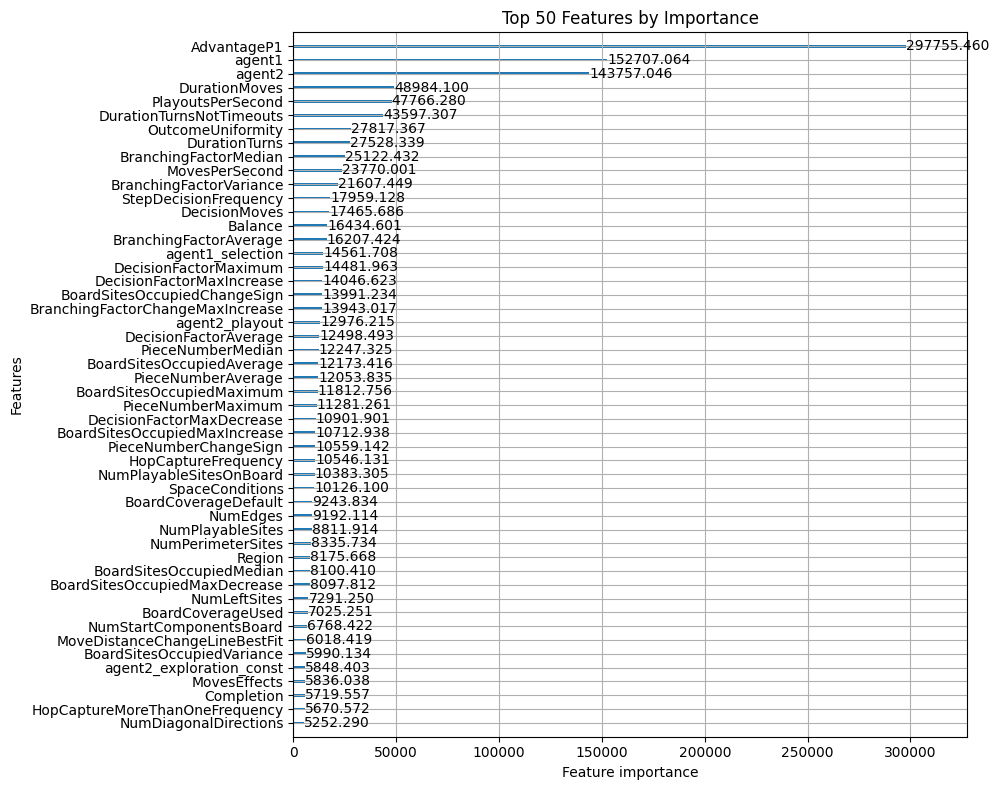

Fold 1 - RMSE: 0.42571812004509185
Fold 2


[100]	valid_0's rmse: 0.510394


[200]	valid_0's rmse: 0.493057


[300]	valid_0's rmse: 0.484705


[400]	valid_0's rmse: 0.476752


[500]	valid_0's rmse: 0.471415


[600]	valid_0's rmse: 0.467806


[700]	valid_0's rmse: 0.465605


[800]	valid_0's rmse: 0.463377


[900]	valid_0's rmse: 0.461846


[1000]	valid_0's rmse: 0.460192


[1100]	valid_0's rmse: 0.458854


[1200]	valid_0's rmse: 0.457678


[1300]	valid_0's rmse: 0.456882


[1400]	valid_0's rmse: 0.455982


[1500]	valid_0's rmse: 0.455257


[1600]	valid_0's rmse: 0.454433


[1700]	valid_0's rmse: 0.453619


[1800]	valid_0's rmse: 0.452961


[1900]	valid_0's rmse: 0.452395


[2000]	valid_0's rmse: 0.451781


[2100]	valid_0's rmse: 0.451394


[2200]	valid_0's rmse: 0.450828


[2300]	valid_0's rmse: 0.450333


[2400]	valid_0's rmse: 0.449871


[2500]	valid_0's rmse: 0.449357


[2600]	valid_0's rmse: 0.449143


[2700]	valid_0's rmse: 0.448952


[2800]	valid_0's rmse: 0.44866


[2900]	valid_0's rmse: 0.448326


[3000]	valid_0's rmse: 0.448151


[3100]	valid_0's rmse: 0.447895


[3200]	valid_0's rmse: 0.447686


[3300]	valid_0's rmse: 0.44759


[3400]	valid_0's rmse: 0.447418


[3500]	valid_0's rmse: 0.447165


[3600]	valid_0's rmse: 0.447089


[3700]	valid_0's rmse: 0.446905


[3800]	valid_0's rmse: 0.446714


[3900]	valid_0's rmse: 0.446624


[4000]	valid_0's rmse: 0.446504


[4100]	valid_0's rmse: 0.446376


[4200]	valid_0's rmse: 0.446175


[4300]	valid_0's rmse: 0.446024


[4400]	valid_0's rmse: 0.445875


[4500]	valid_0's rmse: 0.445799


[4600]	valid_0's rmse: 0.445726


[4700]	valid_0's rmse: 0.445644


[4800]	valid_0's rmse: 0.445507


[4900]	valid_0's rmse: 0.445395


[5000]	valid_0's rmse: 0.445243


[5100]	valid_0's rmse: 0.445194


[5200]	valid_0's rmse: 0.445109


[5300]	valid_0's rmse: 0.444954


[5400]	valid_0's rmse: 0.444928


[5500]	valid_0's rmse: 0.44482


[5600]	valid_0's rmse: 0.444777


[5700]	valid_0's rmse: 0.444577


[5800]	valid_0's rmse: 0.444593


[5900]	valid_0's rmse: 0.444524


[6000]	valid_0's rmse: 0.444443


[6100]	valid_0's rmse: 0.444436


[6200]	valid_0's rmse: 0.444404


[6300]	valid_0's rmse: 0.444314


[6400]	valid_0's rmse: 0.444227


[6500]	valid_0's rmse: 0.444103


[6600]	valid_0's rmse: 0.44411


[6700]	valid_0's rmse: 0.444046


[6800]	valid_0's rmse: 0.443995


[6900]	valid_0's rmse: 0.443973


[7000]	valid_0's rmse: 0.443897


[7100]	valid_0's rmse: 0.443776


[7200]	valid_0's rmse: 0.443747


[7300]	valid_0's rmse: 0.443727


[7400]	valid_0's rmse: 0.443751


[7500]	valid_0's rmse: 0.443717


[7600]	valid_0's rmse: 0.443732


[7700]	valid_0's rmse: 0.443669


[7800]	valid_0's rmse: 0.44364


[7900]	valid_0's rmse: 0.44369


[8000]	valid_0's rmse: 0.443697


[8100]	valid_0's rmse: 0.443614


[8200]	valid_0's rmse: 0.443578


[8300]	valid_0's rmse: 0.443602


[8400]	valid_0's rmse: 0.44359


[8500]	valid_0's rmse: 0.443649


[8600]	valid_0's rmse: 0.443652


[8700]	valid_0's rmse: 0.443668


[8800]	valid_0's rmse: 0.443679


[8900]	valid_0's rmse: 0.44366


[9000]	valid_0's rmse: 0.443597


[9100]	valid_0's rmse: 0.443593


[9200]	valid_0's rmse: 0.44366


[9300]	valid_0's rmse: 0.443626


[9400]	valid_0's rmse: 0.443594


[9500]	valid_0's rmse: 0.443566


[9600]	valid_0's rmse: 0.4435


[9700]	valid_0's rmse: 0.443506


[9800]	valid_0's rmse: 0.443529


[9900]	valid_0's rmse: 0.443475


[10000]	valid_0's rmse: 0.443448


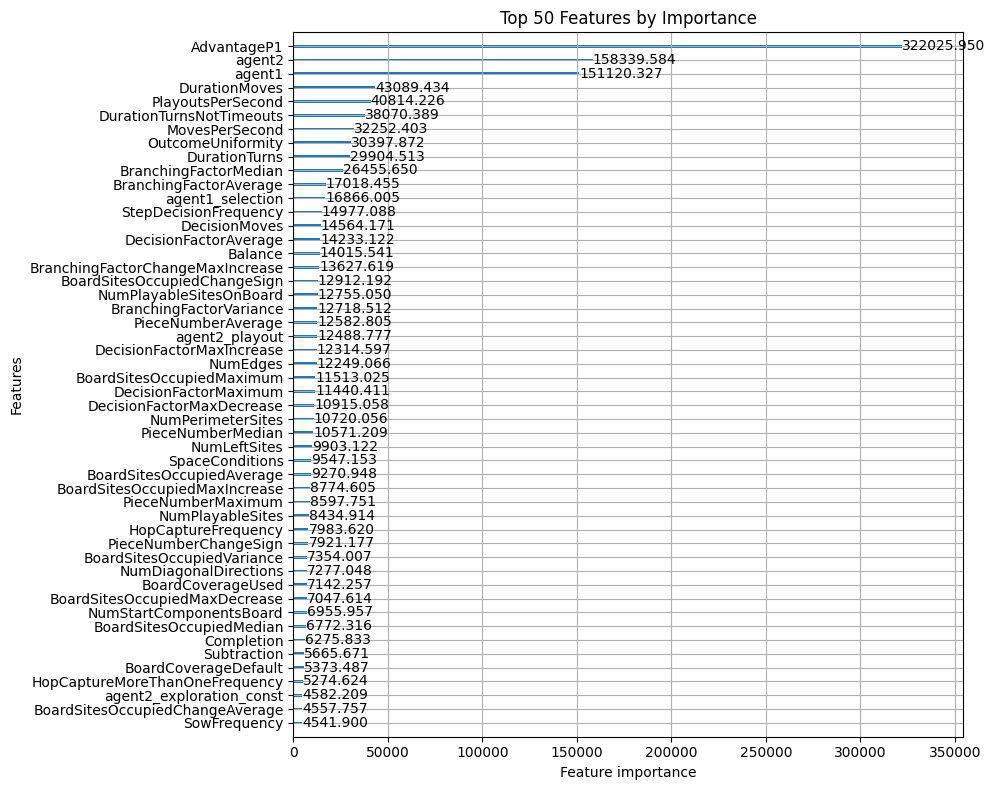

Fold 2 - RMSE: 0.4429732232385767
Fold 3


[100]	valid_0's rmse: 0.508775


[200]	valid_0's rmse: 0.479366


[300]	valid_0's rmse: 0.468006


[400]	valid_0's rmse: 0.461008


[500]	valid_0's rmse: 0.457342


[600]	valid_0's rmse: 0.45385


[700]	valid_0's rmse: 0.451115


[800]	valid_0's rmse: 0.448762


[900]	valid_0's rmse: 0.446756


[1000]	valid_0's rmse: 0.445399


[1100]	valid_0's rmse: 0.443873


[1200]	valid_0's rmse: 0.442591


[1300]	valid_0's rmse: 0.441539


[1400]	valid_0's rmse: 0.440319


[1500]	valid_0's rmse: 0.439515


[1600]	valid_0's rmse: 0.438754


[1700]	valid_0's rmse: 0.438207


[1800]	valid_0's rmse: 0.437468


[1900]	valid_0's rmse: 0.436995


[2000]	valid_0's rmse: 0.436421


[2100]	valid_0's rmse: 0.435979


[2200]	valid_0's rmse: 0.435551


[2300]	valid_0's rmse: 0.435214


[2400]	valid_0's rmse: 0.434835


[2500]	valid_0's rmse: 0.434563


[2600]	valid_0's rmse: 0.434315


[2700]	valid_0's rmse: 0.433867


[2800]	valid_0's rmse: 0.433704


[2900]	valid_0's rmse: 0.433507


[3000]	valid_0's rmse: 0.433315


[3100]	valid_0's rmse: 0.433166


[3200]	valid_0's rmse: 0.432896


[3300]	valid_0's rmse: 0.432643


[3400]	valid_0's rmse: 0.432472


[3500]	valid_0's rmse: 0.43232


[3600]	valid_0's rmse: 0.432145


[3700]	valid_0's rmse: 0.432046


[3800]	valid_0's rmse: 0.431828


[3900]	valid_0's rmse: 0.431658


[4000]	valid_0's rmse: 0.431528


[4100]	valid_0's rmse: 0.431329


[4200]	valid_0's rmse: 0.431192


[4300]	valid_0's rmse: 0.431058


[4400]	valid_0's rmse: 0.430887


[4500]	valid_0's rmse: 0.430719


[4600]	valid_0's rmse: 0.430574


[4700]	valid_0's rmse: 0.430527


[4800]	valid_0's rmse: 0.430393


[4900]	valid_0's rmse: 0.430304


[5000]	valid_0's rmse: 0.430156


[5100]	valid_0's rmse: 0.430029


[5200]	valid_0's rmse: 0.429929


[5300]	valid_0's rmse: 0.429788


[5400]	valid_0's rmse: 0.429664


[5500]	valid_0's rmse: 0.429618


[5600]	valid_0's rmse: 0.429551


[5700]	valid_0's rmse: 0.429509


[5800]	valid_0's rmse: 0.42945


[5900]	valid_0's rmse: 0.429322


[6000]	valid_0's rmse: 0.429281


[6100]	valid_0's rmse: 0.429227


[6200]	valid_0's rmse: 0.429132


[6300]	valid_0's rmse: 0.42904


[6400]	valid_0's rmse: 0.428956


[6500]	valid_0's rmse: 0.42881


[6600]	valid_0's rmse: 0.428813


[6700]	valid_0's rmse: 0.42876


[6800]	valid_0's rmse: 0.428725


[6900]	valid_0's rmse: 0.428657


[7000]	valid_0's rmse: 0.428582


[7100]	valid_0's rmse: 0.428549


[7200]	valid_0's rmse: 0.428578


[7300]	valid_0's rmse: 0.428541


[7400]	valid_0's rmse: 0.428477


[7500]	valid_0's rmse: 0.428483


[7600]	valid_0's rmse: 0.428468


[7700]	valid_0's rmse: 0.428412


[7800]	valid_0's rmse: 0.428405


[7900]	valid_0's rmse: 0.4284


[8000]	valid_0's rmse: 0.428361


[8100]	valid_0's rmse: 0.428374


[8200]	valid_0's rmse: 0.428395


[8300]	valid_0's rmse: 0.428369


[8400]	valid_0's rmse: 0.42832


[8500]	valid_0's rmse: 0.428334


[8600]	valid_0's rmse: 0.428329


[8700]	valid_0's rmse: 0.428339


[8800]	valid_0's rmse: 0.428308


[8900]	valid_0's rmse: 0.428314


[9000]	valid_0's rmse: 0.42826


[9100]	valid_0's rmse: 0.428236


[9200]	valid_0's rmse: 0.428225


[9300]	valid_0's rmse: 0.42818


[9400]	valid_0's rmse: 0.428185


[9500]	valid_0's rmse: 0.428187


[9600]	valid_0's rmse: 0.428172


[9700]	valid_0's rmse: 0.428178


[9800]	valid_0's rmse: 0.428165


[9900]	valid_0's rmse: 0.428085


[10000]	valid_0's rmse: 0.428072


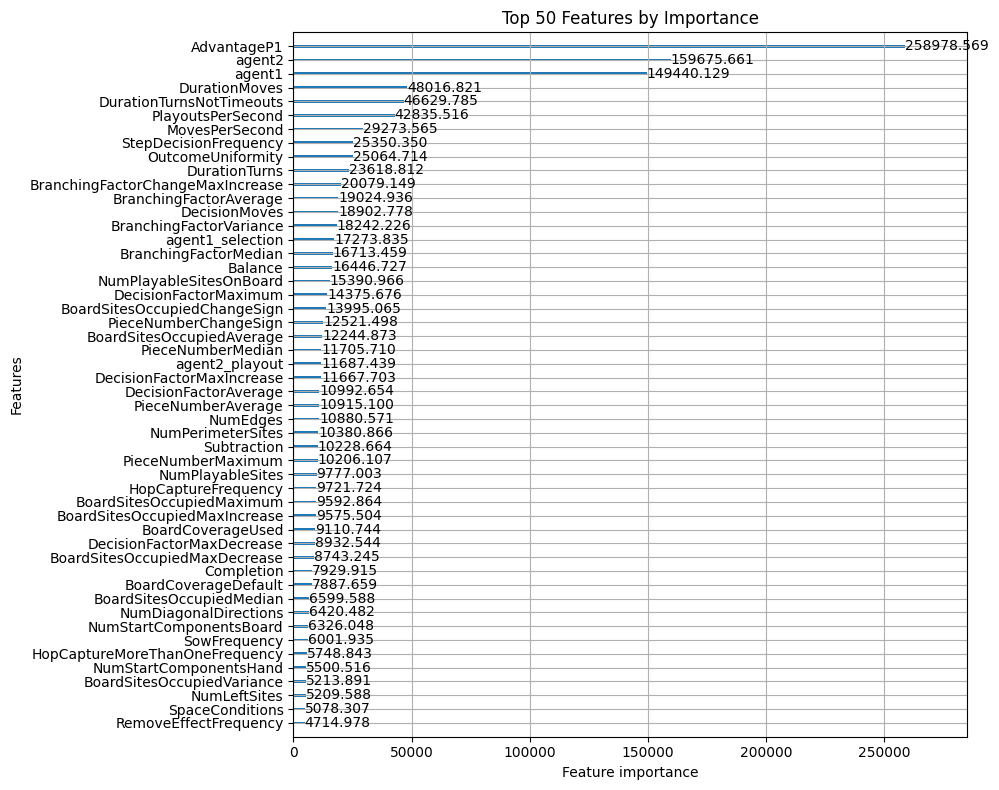

Fold 3 - RMSE: 0.427325685650419
Fold 4


[100]	valid_0's rmse: 0.512729


[200]	valid_0's rmse: 0.489218


[300]	valid_0's rmse: 0.47731


[400]	valid_0's rmse: 0.470763


[500]	valid_0's rmse: 0.465844


[600]	valid_0's rmse: 0.461703


[700]	valid_0's rmse: 0.458117


[800]	valid_0's rmse: 0.455191


[900]	valid_0's rmse: 0.453015


[1000]	valid_0's rmse: 0.451319


[1100]	valid_0's rmse: 0.449592


[1200]	valid_0's rmse: 0.448392


[1300]	valid_0's rmse: 0.447457


[1400]	valid_0's rmse: 0.446617


[1500]	valid_0's rmse: 0.445729


[1600]	valid_0's rmse: 0.444917


[1700]	valid_0's rmse: 0.444067


[1800]	valid_0's rmse: 0.443363


[1900]	valid_0's rmse: 0.442729


[2000]	valid_0's rmse: 0.442087


[2100]	valid_0's rmse: 0.441452


[2200]	valid_0's rmse: 0.441029


[2300]	valid_0's rmse: 0.44061


[2400]	valid_0's rmse: 0.440226


[2500]	valid_0's rmse: 0.439883


[2600]	valid_0's rmse: 0.439436


[2700]	valid_0's rmse: 0.438965


[2800]	valid_0's rmse: 0.438773


[2900]	valid_0's rmse: 0.438537


[3000]	valid_0's rmse: 0.438282


[3100]	valid_0's rmse: 0.438041


[3200]	valid_0's rmse: 0.437822


[3300]	valid_0's rmse: 0.43765


[3400]	valid_0's rmse: 0.43739


[3500]	valid_0's rmse: 0.437159


[3600]	valid_0's rmse: 0.43699


[3700]	valid_0's rmse: 0.436736


[3800]	valid_0's rmse: 0.436531


[3900]	valid_0's rmse: 0.436286


[4000]	valid_0's rmse: 0.436101


[4100]	valid_0's rmse: 0.435943


[4200]	valid_0's rmse: 0.435713


[4300]	valid_0's rmse: 0.435624


[4400]	valid_0's rmse: 0.435453


[4500]	valid_0's rmse: 0.435419


[4600]	valid_0's rmse: 0.435255


[4700]	valid_0's rmse: 0.435203


[4800]	valid_0's rmse: 0.434945


[4900]	valid_0's rmse: 0.434828


[5000]	valid_0's rmse: 0.434782


[5100]	valid_0's rmse: 0.434658


[5200]	valid_0's rmse: 0.434557


[5300]	valid_0's rmse: 0.434388


[5400]	valid_0's rmse: 0.4343


[5500]	valid_0's rmse: 0.434206


[5600]	valid_0's rmse: 0.434123


[5700]	valid_0's rmse: 0.434022


[5800]	valid_0's rmse: 0.433956


[5900]	valid_0's rmse: 0.433933


[6000]	valid_0's rmse: 0.433868


[6100]	valid_0's rmse: 0.433794


[6200]	valid_0's rmse: 0.433735


[6300]	valid_0's rmse: 0.433601


[6400]	valid_0's rmse: 0.433558


[6500]	valid_0's rmse: 0.433461


[6600]	valid_0's rmse: 0.433379


[6700]	valid_0's rmse: 0.433345


[6800]	valid_0's rmse: 0.433274


[6900]	valid_0's rmse: 0.433305


[7000]	valid_0's rmse: 0.433294


[7100]	valid_0's rmse: 0.433173


[7200]	valid_0's rmse: 0.433146


[7300]	valid_0's rmse: 0.433073


[7400]	valid_0's rmse: 0.43299


[7500]	valid_0's rmse: 0.432917


[7600]	valid_0's rmse: 0.432895


[7700]	valid_0's rmse: 0.432866


[7800]	valid_0's rmse: 0.432765


[7900]	valid_0's rmse: 0.432743


[8000]	valid_0's rmse: 0.43263


[8100]	valid_0's rmse: 0.432564


[8200]	valid_0's rmse: 0.432499


[8300]	valid_0's rmse: 0.432443


[8400]	valid_0's rmse: 0.432443


[8500]	valid_0's rmse: 0.432401


[8600]	valid_0's rmse: 0.432387


[8700]	valid_0's rmse: 0.432393


[8800]	valid_0's rmse: 0.432381


[8900]	valid_0's rmse: 0.432372


[9000]	valid_0's rmse: 0.432301


[9100]	valid_0's rmse: 0.432284


[9200]	valid_0's rmse: 0.432298


[9300]	valid_0's rmse: 0.432257


[9400]	valid_0's rmse: 0.432249


[9500]	valid_0's rmse: 0.432216


[9600]	valid_0's rmse: 0.432192


[9700]	valid_0's rmse: 0.432106


[9800]	valid_0's rmse: 0.432141


[9900]	valid_0's rmse: 0.432072


[10000]	valid_0's rmse: 0.432001


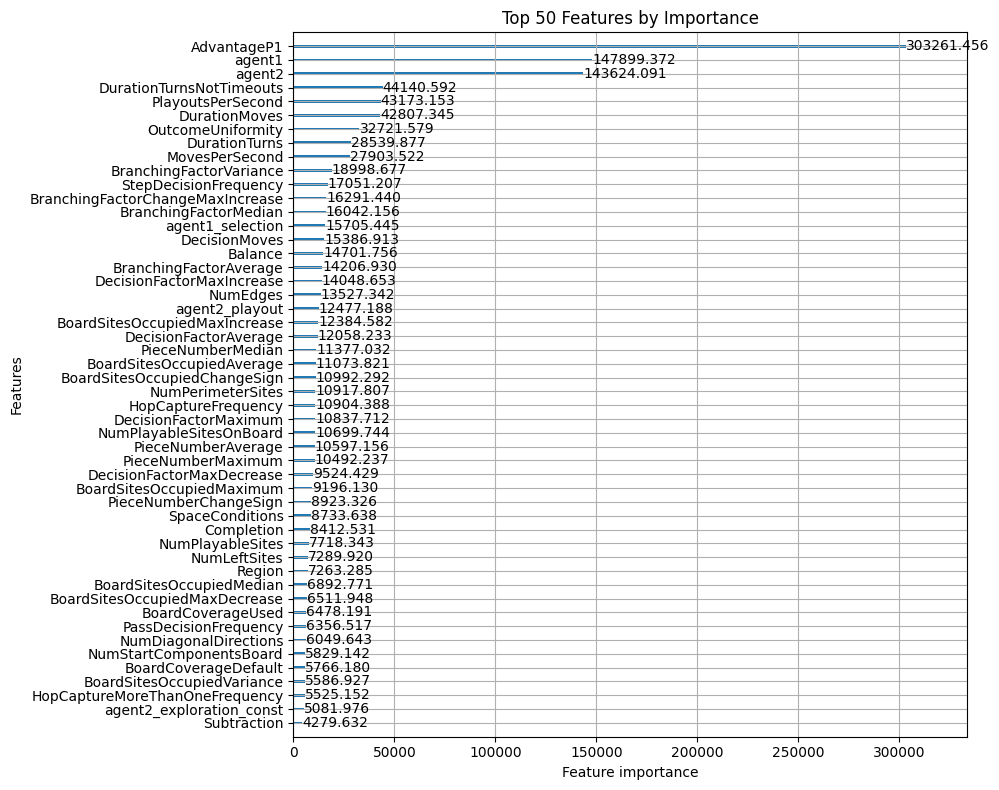

Fold 4 - RMSE: 0.43123140885673117
Fold 5


[100]	valid_0's rmse: 0.489991


[200]	valid_0's rmse: 0.466721


[300]	valid_0's rmse: 0.452409


[400]	valid_0's rmse: 0.445019


[500]	valid_0's rmse: 0.439723


[600]	valid_0's rmse: 0.435154


[700]	valid_0's rmse: 0.431643


[800]	valid_0's rmse: 0.428584


[900]	valid_0's rmse: 0.42614


[1000]	valid_0's rmse: 0.424254


[1100]	valid_0's rmse: 0.422551


[1200]	valid_0's rmse: 0.421242


[1300]	valid_0's rmse: 0.420005


[1400]	valid_0's rmse: 0.418675


[1500]	valid_0's rmse: 0.417543


[1600]	valid_0's rmse: 0.416612


[1700]	valid_0's rmse: 0.415914


[1800]	valid_0's rmse: 0.415049


[1900]	valid_0's rmse: 0.41429


[2000]	valid_0's rmse: 0.413629


[2100]	valid_0's rmse: 0.412988


[2200]	valid_0's rmse: 0.412416


[2300]	valid_0's rmse: 0.411929


[2400]	valid_0's rmse: 0.411493


[2500]	valid_0's rmse: 0.411164


[2600]	valid_0's rmse: 0.410924


[2700]	valid_0's rmse: 0.410615


[2800]	valid_0's rmse: 0.410182


[2900]	valid_0's rmse: 0.40979


[3000]	valid_0's rmse: 0.409566


[3100]	valid_0's rmse: 0.409187


[3200]	valid_0's rmse: 0.408915


[3300]	valid_0's rmse: 0.408613


[3400]	valid_0's rmse: 0.408421


[3500]	valid_0's rmse: 0.408219


[3600]	valid_0's rmse: 0.408031


[3700]	valid_0's rmse: 0.407893


[3800]	valid_0's rmse: 0.407745


[3900]	valid_0's rmse: 0.407548


[4000]	valid_0's rmse: 0.407365


[4100]	valid_0's rmse: 0.407176


[4200]	valid_0's rmse: 0.40705


[4300]	valid_0's rmse: 0.406968


[4400]	valid_0's rmse: 0.406794


[4500]	valid_0's rmse: 0.406641


[4600]	valid_0's rmse: 0.406551


[4700]	valid_0's rmse: 0.406488


[4800]	valid_0's rmse: 0.406488


[4900]	valid_0's rmse: 0.406401


[5000]	valid_0's rmse: 0.406333


[5100]	valid_0's rmse: 0.406228


[5200]	valid_0's rmse: 0.406196


[5300]	valid_0's rmse: 0.406102


[5400]	valid_0's rmse: 0.406008


[5500]	valid_0's rmse: 0.405997


[5600]	valid_0's rmse: 0.405961


[5700]	valid_0's rmse: 0.405904


[5800]	valid_0's rmse: 0.405841


[5900]	valid_0's rmse: 0.405845


[6000]	valid_0's rmse: 0.405852


[6100]	valid_0's rmse: 0.405794


[6200]	valid_0's rmse: 0.405704


[6300]	valid_0's rmse: 0.405586


[6400]	valid_0's rmse: 0.40558


[6500]	valid_0's rmse: 0.405489


[6600]	valid_0's rmse: 0.405411


[6700]	valid_0's rmse: 0.405368


[6800]	valid_0's rmse: 0.405317


[6900]	valid_0's rmse: 0.40525


[7000]	valid_0's rmse: 0.405199


[7100]	valid_0's rmse: 0.405237


[7200]	valid_0's rmse: 0.405234


[7300]	valid_0's rmse: 0.405203


[7400]	valid_0's rmse: 0.40515


[7500]	valid_0's rmse: 0.405105


[7600]	valid_0's rmse: 0.405115


[7700]	valid_0's rmse: 0.405004


[7800]	valid_0's rmse: 0.405029


[7900]	valid_0's rmse: 0.40503


[8000]	valid_0's rmse: 0.404986


[8100]	valid_0's rmse: 0.404978


[8200]	valid_0's rmse: 0.404924


[8300]	valid_0's rmse: 0.404884


[8400]	valid_0's rmse: 0.404876


[8500]	valid_0's rmse: 0.404794


[8600]	valid_0's rmse: 0.404751


[8700]	valid_0's rmse: 0.404801


[8800]	valid_0's rmse: 0.404779


[8900]	valid_0's rmse: 0.404798


[9000]	valid_0's rmse: 0.404804


[9100]	valid_0's rmse: 0.404825


[9200]	valid_0's rmse: 0.404817


[9300]	valid_0's rmse: 0.404801


[9400]	valid_0's rmse: 0.404774


[9500]	valid_0's rmse: 0.404787


[9600]	valid_0's rmse: 0.404796


[9700]	valid_0's rmse: 0.404805


[9800]	valid_0's rmse: 0.404799


[9900]	valid_0's rmse: 0.404771


[10000]	valid_0's rmse: 0.404766


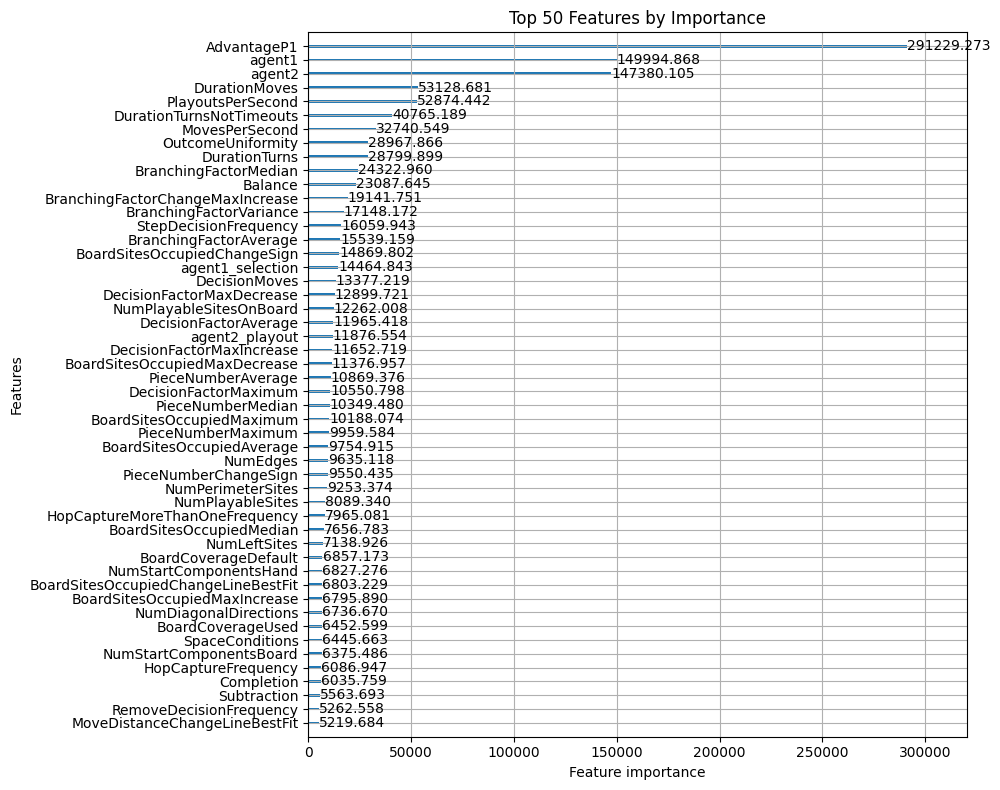

Fold 5 - RMSE: 0.40431031670511486
List of oof scores: [0.42571812004509185, 0.4429732232385767, 0.427325685650419, 0.43123140885673117, 0.40431031670511486]
Average oof score: 0.42631175089918666


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.478303


[200]	valid_0's rmse: 0.457149


[300]	valid_0's rmse: 0.447664


[400]	valid_0's rmse: 0.440938


[500]	valid_0's rmse: 0.436238


[600]	valid_0's rmse: 0.433469


[700]	valid_0's rmse: 0.431259


[800]	valid_0's rmse: 0.429085


[900]	valid_0's rmse: 0.427516


[1000]	valid_0's rmse: 0.425993


[1100]	valid_0's rmse: 0.424479


[1200]	valid_0's rmse: 0.423409


[1300]	valid_0's rmse: 0.42262


[1400]	valid_0's rmse: 0.421945


[1500]	valid_0's rmse: 0.421159


[1600]	valid_0's rmse: 0.42065


[1700]	valid_0's rmse: 0.42009


[1800]	valid_0's rmse: 0.419536


[1900]	valid_0's rmse: 0.419052


[2000]	valid_0's rmse: 0.418486


[2100]	valid_0's rmse: 0.417978


[2200]	valid_0's rmse: 0.417552


[2300]	valid_0's rmse: 0.417196


[2400]	valid_0's rmse: 0.417024


[2500]	valid_0's rmse: 0.416675


[2600]	valid_0's rmse: 0.416536


[2700]	valid_0's rmse: 0.416119


[2800]	valid_0's rmse: 0.415873


[2900]	valid_0's rmse: 0.415515


[3000]	valid_0's rmse: 0.41528


[3100]	valid_0's rmse: 0.415083


[3200]	valid_0's rmse: 0.414828


[3300]	valid_0's rmse: 0.414716


[3400]	valid_0's rmse: 0.414483


[3500]	valid_0's rmse: 0.414312


[3600]	valid_0's rmse: 0.414116


[3700]	valid_0's rmse: 0.414043


[3800]	valid_0's rmse: 0.413906


[3900]	valid_0's rmse: 0.413848


[4000]	valid_0's rmse: 0.413684


[4100]	valid_0's rmse: 0.413547


[4200]	valid_0's rmse: 0.413399


[4300]	valid_0's rmse: 0.413179


[4400]	valid_0's rmse: 0.413029


[4500]	valid_0's rmse: 0.412853


[4600]	valid_0's rmse: 0.412711


[4700]	valid_0's rmse: 0.412579


[4800]	valid_0's rmse: 0.412539


[4900]	valid_0's rmse: 0.412496


[5000]	valid_0's rmse: 0.412369


[5100]	valid_0's rmse: 0.412238


[5200]	valid_0's rmse: 0.412077


[5300]	valid_0's rmse: 0.411997


[5400]	valid_0's rmse: 0.41186


[5500]	valid_0's rmse: 0.411752


[5600]	valid_0's rmse: 0.411642


[5700]	valid_0's rmse: 0.411599


[5800]	valid_0's rmse: 0.411513


[5900]	valid_0's rmse: 0.411429


[6000]	valid_0's rmse: 0.41135


[6100]	valid_0's rmse: 0.411279


[6200]	valid_0's rmse: 0.411235


[6300]	valid_0's rmse: 0.411189


[6400]	valid_0's rmse: 0.411132


[6500]	valid_0's rmse: 0.411088


[6600]	valid_0's rmse: 0.411017


[6700]	valid_0's rmse: 0.410935


[6800]	valid_0's rmse: 0.410832


[6900]	valid_0's rmse: 0.410762


[7000]	valid_0's rmse: 0.410769


[7100]	valid_0's rmse: 0.410683


[7200]	valid_0's rmse: 0.410597


[7300]	valid_0's rmse: 0.410524


[7400]	valid_0's rmse: 0.410459


[7500]	valid_0's rmse: 0.410369


[7600]	valid_0's rmse: 0.410293


[7700]	valid_0's rmse: 0.410278


[7800]	valid_0's rmse: 0.410227


[7900]	valid_0's rmse: 0.410173


[8000]	valid_0's rmse: 0.410095


[8100]	valid_0's rmse: 0.410074


[8200]	valid_0's rmse: 0.410044


[8300]	valid_0's rmse: 0.410023


[8400]	valid_0's rmse: 0.409971


[8500]	valid_0's rmse: 0.409934


[8600]	valid_0's rmse: 0.409913


[8700]	valid_0's rmse: 0.40988


[8800]	valid_0's rmse: 0.40989


[8900]	valid_0's rmse: 0.409808


[9000]	valid_0's rmse: 0.409805


[9100]	valid_0's rmse: 0.409782


[9200]	valid_0's rmse: 0.409734


[9300]	valid_0's rmse: 0.409699


[9400]	valid_0's rmse: 0.409694


[9500]	valid_0's rmse: 0.409681


[9600]	valid_0's rmse: 0.409669


[9700]	valid_0's rmse: 0.409652


[9800]	valid_0's rmse: 0.409656


[9900]	valid_0's rmse: 0.409639


[10000]	valid_0's rmse: 0.409585


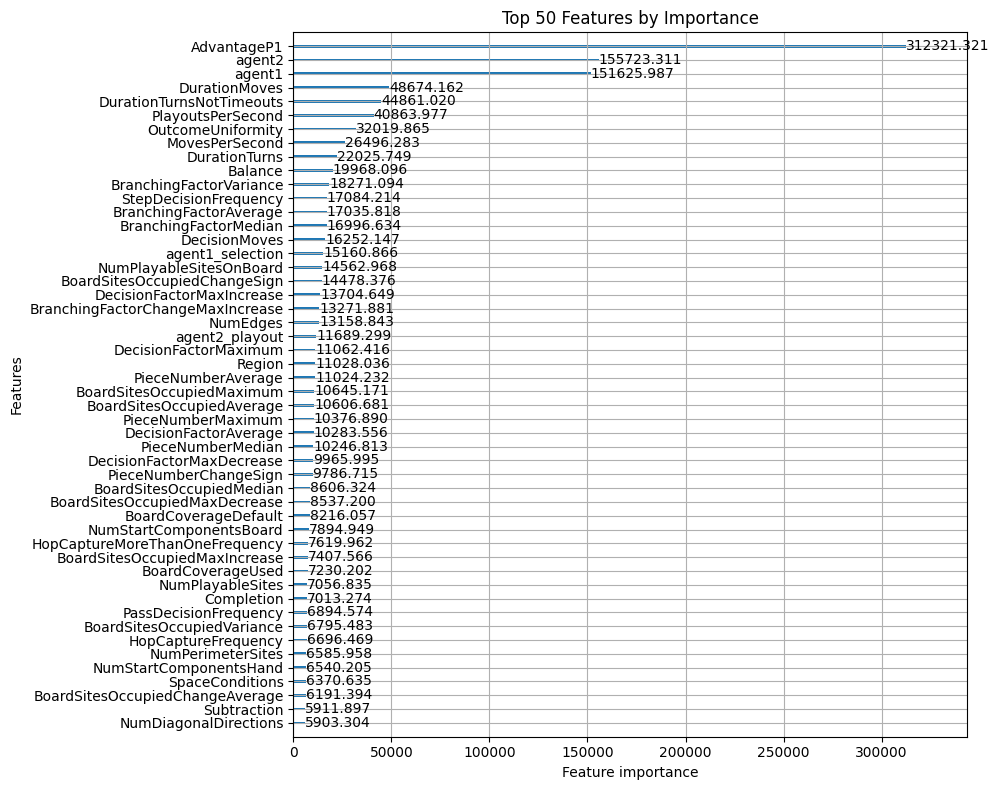

Fold 1 - RMSE: 0.4090814555171167
Fold 2


[100]	valid_0's rmse: 0.461376


[200]	valid_0's rmse: 0.438519


[300]	valid_0's rmse: 0.429525


[400]	valid_0's rmse: 0.423741


[500]	valid_0's rmse: 0.420066


[600]	valid_0's rmse: 0.417915


[700]	valid_0's rmse: 0.415925


[800]	valid_0's rmse: 0.413774


[900]	valid_0's rmse: 0.411854


[1000]	valid_0's rmse: 0.410694


[1100]	valid_0's rmse: 0.40997


[1200]	valid_0's rmse: 0.408914


[1300]	valid_0's rmse: 0.408137


[1400]	valid_0's rmse: 0.407459


[1500]	valid_0's rmse: 0.406835


[1600]	valid_0's rmse: 0.406334


[1700]	valid_0's rmse: 0.405866


[1800]	valid_0's rmse: 0.405513


[1900]	valid_0's rmse: 0.405117


[2000]	valid_0's rmse: 0.404783


[2100]	valid_0's rmse: 0.404528


[2200]	valid_0's rmse: 0.404243


[2300]	valid_0's rmse: 0.403901


[2400]	valid_0's rmse: 0.403641


[2500]	valid_0's rmse: 0.403255


[2600]	valid_0's rmse: 0.403098


[2700]	valid_0's rmse: 0.402922


[2800]	valid_0's rmse: 0.402755


[2900]	valid_0's rmse: 0.40251


[3000]	valid_0's rmse: 0.402379


[3100]	valid_0's rmse: 0.402244


[3200]	valid_0's rmse: 0.402064


[3300]	valid_0's rmse: 0.401966


[3400]	valid_0's rmse: 0.401888


[3500]	valid_0's rmse: 0.401714


[3600]	valid_0's rmse: 0.401671


[3700]	valid_0's rmse: 0.401555


[3800]	valid_0's rmse: 0.401453


[3900]	valid_0's rmse: 0.401483


[4000]	valid_0's rmse: 0.401423


[4100]	valid_0's rmse: 0.401305


[4200]	valid_0's rmse: 0.401231


[4300]	valid_0's rmse: 0.401174


[4400]	valid_0's rmse: 0.401047


[4500]	valid_0's rmse: 0.400997


[4600]	valid_0's rmse: 0.400884


[4700]	valid_0's rmse: 0.400873


[4800]	valid_0's rmse: 0.400859


[4900]	valid_0's rmse: 0.400781


[5000]	valid_0's rmse: 0.400708


[5100]	valid_0's rmse: 0.400649


[5200]	valid_0's rmse: 0.400601


[5300]	valid_0's rmse: 0.400541


[5400]	valid_0's rmse: 0.40051


[5500]	valid_0's rmse: 0.400446


[5600]	valid_0's rmse: 0.400451


[5700]	valid_0's rmse: 0.400394


[5800]	valid_0's rmse: 0.400339


[5900]	valid_0's rmse: 0.400329


[6000]	valid_0's rmse: 0.4003


[6100]	valid_0's rmse: 0.400281


[6200]	valid_0's rmse: 0.400326


[6300]	valid_0's rmse: 0.400294


[6400]	valid_0's rmse: 0.400277


[6500]	valid_0's rmse: 0.400257


[6600]	valid_0's rmse: 0.400251


[6700]	valid_0's rmse: 0.400249


[6800]	valid_0's rmse: 0.400301


[6900]	valid_0's rmse: 0.400338


[7000]	valid_0's rmse: 0.400337


[7100]	valid_0's rmse: 0.400414


[7200]	valid_0's rmse: 0.400461


[7300]	valid_0's rmse: 0.400489


[7400]	valid_0's rmse: 0.40042


[7500]	valid_0's rmse: 0.400432


[7600]	valid_0's rmse: 0.400526


[7700]	valid_0's rmse: 0.400548


[7800]	valid_0's rmse: 0.400559


[7900]	valid_0's rmse: 0.400529


[8000]	valid_0's rmse: 0.400484


[8100]	valid_0's rmse: 0.400496


[8200]	valid_0's rmse: 0.400505


[8300]	valid_0's rmse: 0.400541


[8400]	valid_0's rmse: 0.400567


[8500]	valid_0's rmse: 0.400585


[8600]	valid_0's rmse: 0.400582


[8700]	valid_0's rmse: 0.40058


[8800]	valid_0's rmse: 0.40059


[8900]	valid_0's rmse: 0.400669


[9000]	valid_0's rmse: 0.400659


[9100]	valid_0's rmse: 0.40066


[9200]	valid_0's rmse: 0.40063


[9300]	valid_0's rmse: 0.400641


[9400]	valid_0's rmse: 0.400656


[9500]	valid_0's rmse: 0.400685


[9600]	valid_0's rmse: 0.400639


[9700]	valid_0's rmse: 0.40066


[9800]	valid_0's rmse: 0.400678


[9900]	valid_0's rmse: 0.400634


[10000]	valid_0's rmse: 0.40063


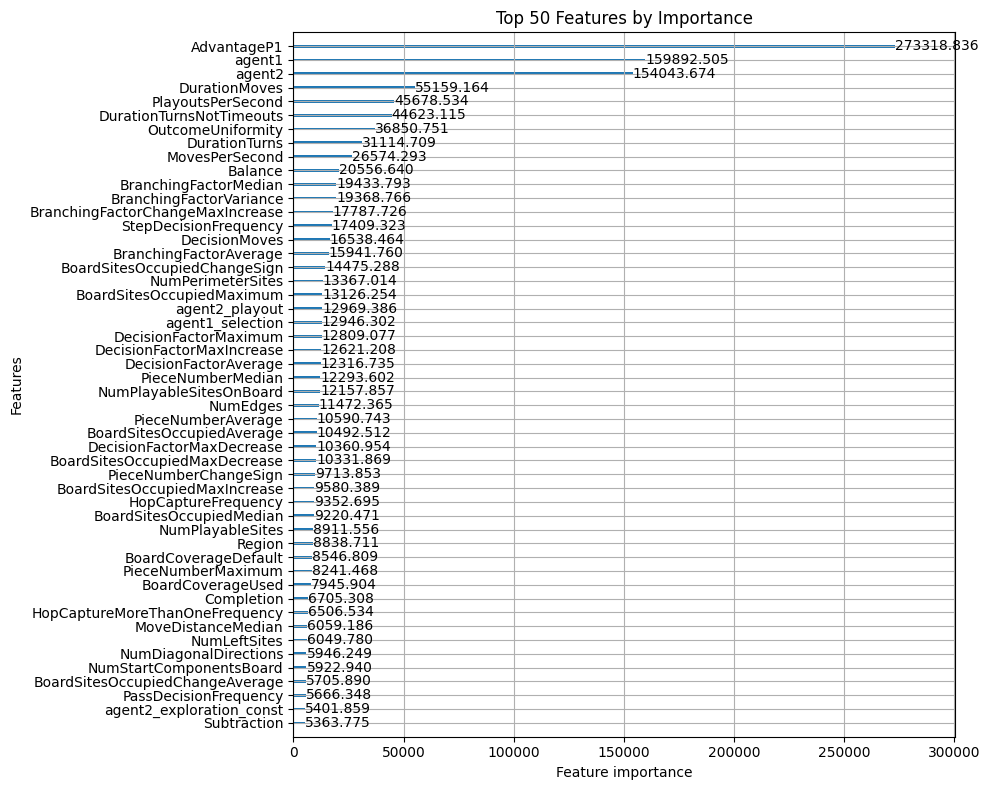

Fold 2 - RMSE: 0.39987774036222845
Fold 3


[100]	valid_0's rmse: 0.521075


[200]	valid_0's rmse: 0.494718


[300]	valid_0's rmse: 0.48245


[400]	valid_0's rmse: 0.473236


[500]	valid_0's rmse: 0.466704


[600]	valid_0's rmse: 0.461845


[700]	valid_0's rmse: 0.457548


[800]	valid_0's rmse: 0.454006


[900]	valid_0's rmse: 0.451163


[1000]	valid_0's rmse: 0.448458


[1100]	valid_0's rmse: 0.446276


[1200]	valid_0's rmse: 0.444556


[1300]	valid_0's rmse: 0.443621


[1400]	valid_0's rmse: 0.442088


[1500]	valid_0's rmse: 0.440939


[1600]	valid_0's rmse: 0.439855


[1700]	valid_0's rmse: 0.4391


[1800]	valid_0's rmse: 0.438201


[1900]	valid_0's rmse: 0.4375


[2000]	valid_0's rmse: 0.436679


[2100]	valid_0's rmse: 0.436106


[2200]	valid_0's rmse: 0.43563


[2300]	valid_0's rmse: 0.435185


[2400]	valid_0's rmse: 0.434628


[2500]	valid_0's rmse: 0.434176


[2600]	valid_0's rmse: 0.433829


[2700]	valid_0's rmse: 0.433453


[2800]	valid_0's rmse: 0.433103


[2900]	valid_0's rmse: 0.432752


[3000]	valid_0's rmse: 0.432417


[3100]	valid_0's rmse: 0.432091


[3200]	valid_0's rmse: 0.431784


[3300]	valid_0's rmse: 0.431541


[3400]	valid_0's rmse: 0.431453


[3500]	valid_0's rmse: 0.431132


[3600]	valid_0's rmse: 0.43084


[3700]	valid_0's rmse: 0.430593


[3800]	valid_0's rmse: 0.430395


[3900]	valid_0's rmse: 0.430188


[4000]	valid_0's rmse: 0.429946


[4100]	valid_0's rmse: 0.429723


[4200]	valid_0's rmse: 0.429571


[4300]	valid_0's rmse: 0.429363


[4400]	valid_0's rmse: 0.429212


[4500]	valid_0's rmse: 0.429027


[4600]	valid_0's rmse: 0.428832


[4700]	valid_0's rmse: 0.428697


[4800]	valid_0's rmse: 0.428521


[4900]	valid_0's rmse: 0.428351


[5000]	valid_0's rmse: 0.428189


[5100]	valid_0's rmse: 0.428066


[5200]	valid_0's rmse: 0.427919


[5300]	valid_0's rmse: 0.427794


[5400]	valid_0's rmse: 0.427677


[5500]	valid_0's rmse: 0.427543


[5600]	valid_0's rmse: 0.427396


[5700]	valid_0's rmse: 0.427242


[5800]	valid_0's rmse: 0.427235


[5900]	valid_0's rmse: 0.427094


[6000]	valid_0's rmse: 0.426999


[6100]	valid_0's rmse: 0.42691


[6200]	valid_0's rmse: 0.426826


[6300]	valid_0's rmse: 0.42681


[6400]	valid_0's rmse: 0.426772


[6500]	valid_0's rmse: 0.426664


[6600]	valid_0's rmse: 0.426626


[6700]	valid_0's rmse: 0.426561


[6800]	valid_0's rmse: 0.426507


[6900]	valid_0's rmse: 0.426457


[7000]	valid_0's rmse: 0.426387


[7100]	valid_0's rmse: 0.426349


[7200]	valid_0's rmse: 0.426328


[7300]	valid_0's rmse: 0.426289


[7400]	valid_0's rmse: 0.426203


[7500]	valid_0's rmse: 0.426161


[7600]	valid_0's rmse: 0.426125


[7700]	valid_0's rmse: 0.42609


[7800]	valid_0's rmse: 0.426012


[7900]	valid_0's rmse: 0.425971


[8000]	valid_0's rmse: 0.425933


[8100]	valid_0's rmse: 0.425908


[8200]	valid_0's rmse: 0.425854


[8300]	valid_0's rmse: 0.425804


[8400]	valid_0's rmse: 0.425755


[8500]	valid_0's rmse: 0.425752


[8600]	valid_0's rmse: 0.425681


[8700]	valid_0's rmse: 0.425605


[8800]	valid_0's rmse: 0.425517


[8900]	valid_0's rmse: 0.425536


[9000]	valid_0's rmse: 0.425465


[9100]	valid_0's rmse: 0.425444


[9200]	valid_0's rmse: 0.425388


[9300]	valid_0's rmse: 0.425366


[9400]	valid_0's rmse: 0.425301


[9500]	valid_0's rmse: 0.425309


[9600]	valid_0's rmse: 0.425282


[9700]	valid_0's rmse: 0.425253


[9800]	valid_0's rmse: 0.425242


[9900]	valid_0's rmse: 0.425245


[10000]	valid_0's rmse: 0.425263


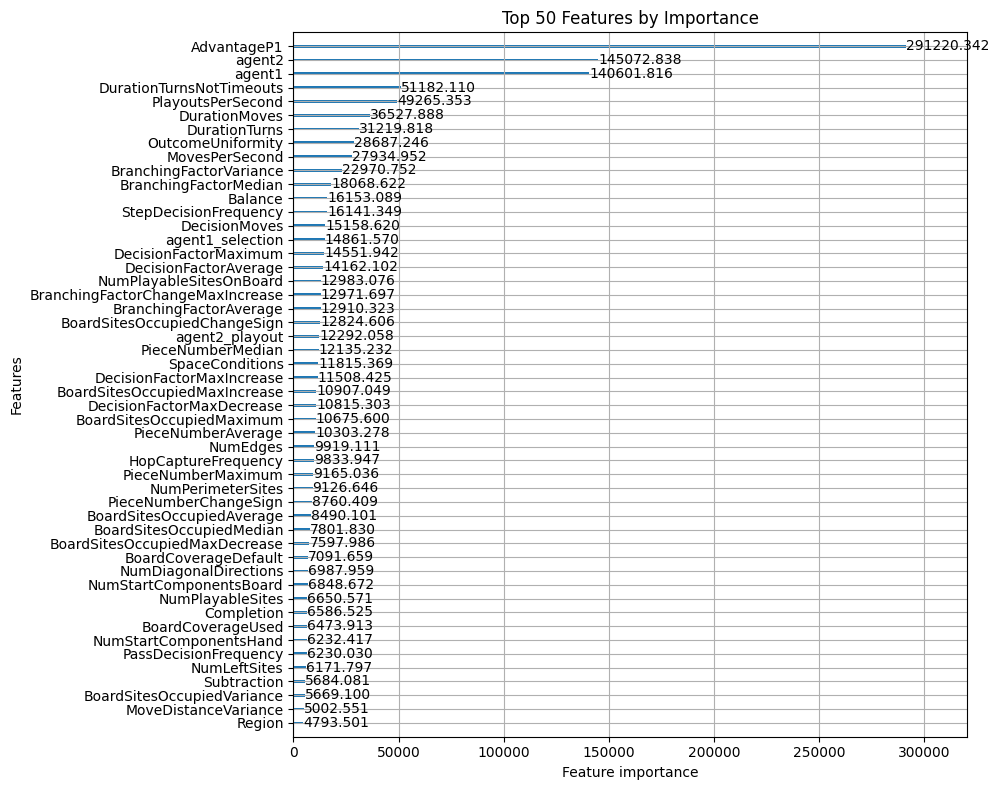

Fold 3 - RMSE: 0.42441467858348025
Fold 4


[100]	valid_0's rmse: 0.524385


[200]	valid_0's rmse: 0.495353


[300]	valid_0's rmse: 0.480165


[400]	valid_0's rmse: 0.472136


[500]	valid_0's rmse: 0.465712


[600]	valid_0's rmse: 0.462372


[700]	valid_0's rmse: 0.459381


[800]	valid_0's rmse: 0.456524


[900]	valid_0's rmse: 0.454336


[1000]	valid_0's rmse: 0.452383


[1100]	valid_0's rmse: 0.451283


[1200]	valid_0's rmse: 0.449957


[1300]	valid_0's rmse: 0.448884


[1400]	valid_0's rmse: 0.44787


[1500]	valid_0's rmse: 0.447047


[1600]	valid_0's rmse: 0.446154


[1700]	valid_0's rmse: 0.445334


[1800]	valid_0's rmse: 0.44482


[1900]	valid_0's rmse: 0.444287


[2000]	valid_0's rmse: 0.443792


[2100]	valid_0's rmse: 0.44329


[2200]	valid_0's rmse: 0.442882


[2300]	valid_0's rmse: 0.442481


[2400]	valid_0's rmse: 0.442096


[2500]	valid_0's rmse: 0.441793


[2600]	valid_0's rmse: 0.441488


[2700]	valid_0's rmse: 0.441185


[2800]	valid_0's rmse: 0.440902


[2900]	valid_0's rmse: 0.440529


[3000]	valid_0's rmse: 0.440212


[3100]	valid_0's rmse: 0.440009


[3200]	valid_0's rmse: 0.439645


[3300]	valid_0's rmse: 0.439402


[3400]	valid_0's rmse: 0.439156


[3500]	valid_0's rmse: 0.438937


[3600]	valid_0's rmse: 0.438746


[3700]	valid_0's rmse: 0.438486


[3800]	valid_0's rmse: 0.438343


[3900]	valid_0's rmse: 0.43822


[4000]	valid_0's rmse: 0.438063


[4100]	valid_0's rmse: 0.437863


[4200]	valid_0's rmse: 0.437768


[4300]	valid_0's rmse: 0.437663


[4400]	valid_0's rmse: 0.437687


[4500]	valid_0's rmse: 0.437484


[4600]	valid_0's rmse: 0.437373


[4700]	valid_0's rmse: 0.437255


[4800]	valid_0's rmse: 0.437209


[4900]	valid_0's rmse: 0.437115


[5000]	valid_0's rmse: 0.437052


[5100]	valid_0's rmse: 0.436911


[5200]	valid_0's rmse: 0.436836


[5300]	valid_0's rmse: 0.436763


[5400]	valid_0's rmse: 0.436701


[5500]	valid_0's rmse: 0.436578


[5600]	valid_0's rmse: 0.436434


[5700]	valid_0's rmse: 0.436399


[5800]	valid_0's rmse: 0.436361


[5900]	valid_0's rmse: 0.436242


[6000]	valid_0's rmse: 0.436183


[6100]	valid_0's rmse: 0.436083


[6200]	valid_0's rmse: 0.436019


[6300]	valid_0's rmse: 0.435924


[6400]	valid_0's rmse: 0.435867


[6500]	valid_0's rmse: 0.435716


[6600]	valid_0's rmse: 0.435669


[6700]	valid_0's rmse: 0.43562


[6800]	valid_0's rmse: 0.435566


[6900]	valid_0's rmse: 0.435525


[7000]	valid_0's rmse: 0.435513


[7100]	valid_0's rmse: 0.435486


[7200]	valid_0's rmse: 0.435407


[7300]	valid_0's rmse: 0.435388


[7400]	valid_0's rmse: 0.435365


[7500]	valid_0's rmse: 0.435317


[7600]	valid_0's rmse: 0.435303


[7700]	valid_0's rmse: 0.435213


[7800]	valid_0's rmse: 0.435157


[7900]	valid_0's rmse: 0.435189


[8000]	valid_0's rmse: 0.435116


[8100]	valid_0's rmse: 0.43512


[8200]	valid_0's rmse: 0.435064


[8300]	valid_0's rmse: 0.434979


[8400]	valid_0's rmse: 0.434964


[8500]	valid_0's rmse: 0.434908


[8600]	valid_0's rmse: 0.434906


[8700]	valid_0's rmse: 0.434852


[8800]	valid_0's rmse: 0.434842


[8900]	valid_0's rmse: 0.434766


[9000]	valid_0's rmse: 0.434746


[9100]	valid_0's rmse: 0.434722


[9200]	valid_0's rmse: 0.434751


[9300]	valid_0's rmse: 0.43475


[9400]	valid_0's rmse: 0.434784


[9500]	valid_0's rmse: 0.434766


[9600]	valid_0's rmse: 0.434749


[9700]	valid_0's rmse: 0.434748


[9800]	valid_0's rmse: 0.434762


[9900]	valid_0's rmse: 0.434683


[10000]	valid_0's rmse: 0.434687


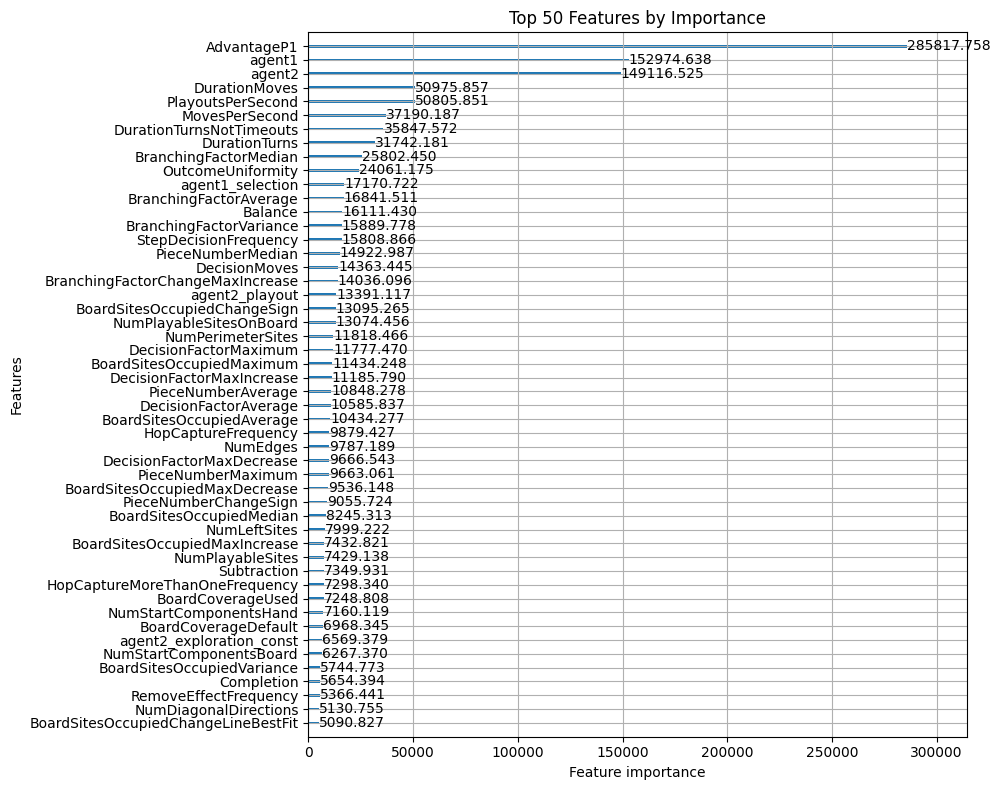

Fold 4 - RMSE: 0.4342117205470023
Fold 5


[100]	valid_0's rmse: 0.516394


[200]	valid_0's rmse: 0.491427


[300]	valid_0's rmse: 0.4752


[400]	valid_0's rmse: 0.467466


[500]	valid_0's rmse: 0.462009


[600]	valid_0's rmse: 0.457429


[700]	valid_0's rmse: 0.453752


[800]	valid_0's rmse: 0.450714


[900]	valid_0's rmse: 0.44835


[1000]	valid_0's rmse: 0.446328


[1100]	valid_0's rmse: 0.444594


[1200]	valid_0's rmse: 0.442841


[1300]	valid_0's rmse: 0.441583


[1400]	valid_0's rmse: 0.440257


[1500]	valid_0's rmse: 0.439133


[1600]	valid_0's rmse: 0.438216


[1700]	valid_0's rmse: 0.43729


[1800]	valid_0's rmse: 0.436703


[1900]	valid_0's rmse: 0.435783


[2000]	valid_0's rmse: 0.435148


[2100]	valid_0's rmse: 0.434669


[2200]	valid_0's rmse: 0.434151


[2300]	valid_0's rmse: 0.433693


[2400]	valid_0's rmse: 0.432957


[2500]	valid_0's rmse: 0.432487


[2600]	valid_0's rmse: 0.432046


[2700]	valid_0's rmse: 0.431538


[2800]	valid_0's rmse: 0.431263


[2900]	valid_0's rmse: 0.431014


[3000]	valid_0's rmse: 0.430803


[3100]	valid_0's rmse: 0.43043


[3200]	valid_0's rmse: 0.430145


[3300]	valid_0's rmse: 0.429844


[3400]	valid_0's rmse: 0.42953


[3500]	valid_0's rmse: 0.429267


[3600]	valid_0's rmse: 0.429117


[3700]	valid_0's rmse: 0.428929


[3800]	valid_0's rmse: 0.428661


[3900]	valid_0's rmse: 0.428488


[4000]	valid_0's rmse: 0.428278


[4100]	valid_0's rmse: 0.428176


[4200]	valid_0's rmse: 0.428046


[4300]	valid_0's rmse: 0.427886


[4400]	valid_0's rmse: 0.427689


[4500]	valid_0's rmse: 0.427522


[4600]	valid_0's rmse: 0.427287


[4700]	valid_0's rmse: 0.427214


[4800]	valid_0's rmse: 0.427049


[4900]	valid_0's rmse: 0.426898


[5000]	valid_0's rmse: 0.426784


[5100]	valid_0's rmse: 0.426655


[5200]	valid_0's rmse: 0.426535


[5300]	valid_0's rmse: 0.426498


[5400]	valid_0's rmse: 0.426441


[5500]	valid_0's rmse: 0.426334


[5600]	valid_0's rmse: 0.426269


[5700]	valid_0's rmse: 0.42619


[5800]	valid_0's rmse: 0.426086


[5900]	valid_0's rmse: 0.426058


[6000]	valid_0's rmse: 0.425948


[6100]	valid_0's rmse: 0.425835


[6200]	valid_0's rmse: 0.42574


[6300]	valid_0's rmse: 0.42568


[6400]	valid_0's rmse: 0.4256


[6500]	valid_0's rmse: 0.425581


[6600]	valid_0's rmse: 0.425446


[6700]	valid_0's rmse: 0.425437


[6800]	valid_0's rmse: 0.425395


[6900]	valid_0's rmse: 0.425279


[7000]	valid_0's rmse: 0.425231


[7100]	valid_0's rmse: 0.425202


[7200]	valid_0's rmse: 0.425154


[7300]	valid_0's rmse: 0.425052


[7400]	valid_0's rmse: 0.424979


[7500]	valid_0's rmse: 0.424945


[7600]	valid_0's rmse: 0.424914


[7700]	valid_0's rmse: 0.424822


[7800]	valid_0's rmse: 0.424784


[7900]	valid_0's rmse: 0.424769


[8000]	valid_0's rmse: 0.424739


[8100]	valid_0's rmse: 0.42475


[8200]	valid_0's rmse: 0.424711


[8300]	valid_0's rmse: 0.424696


[8400]	valid_0's rmse: 0.424658


[8500]	valid_0's rmse: 0.424564


[8600]	valid_0's rmse: 0.424557


[8700]	valid_0's rmse: 0.424523


[8800]	valid_0's rmse: 0.424509


[8900]	valid_0's rmse: 0.424464


[9000]	valid_0's rmse: 0.424452


[9100]	valid_0's rmse: 0.424475


[9200]	valid_0's rmse: 0.424458


[9300]	valid_0's rmse: 0.424434


[9400]	valid_0's rmse: 0.424451


[9500]	valid_0's rmse: 0.424436


[9600]	valid_0's rmse: 0.424418


[9700]	valid_0's rmse: 0.424351


[9800]	valid_0's rmse: 0.424325


[9900]	valid_0's rmse: 0.424322


[10000]	valid_0's rmse: 0.424293


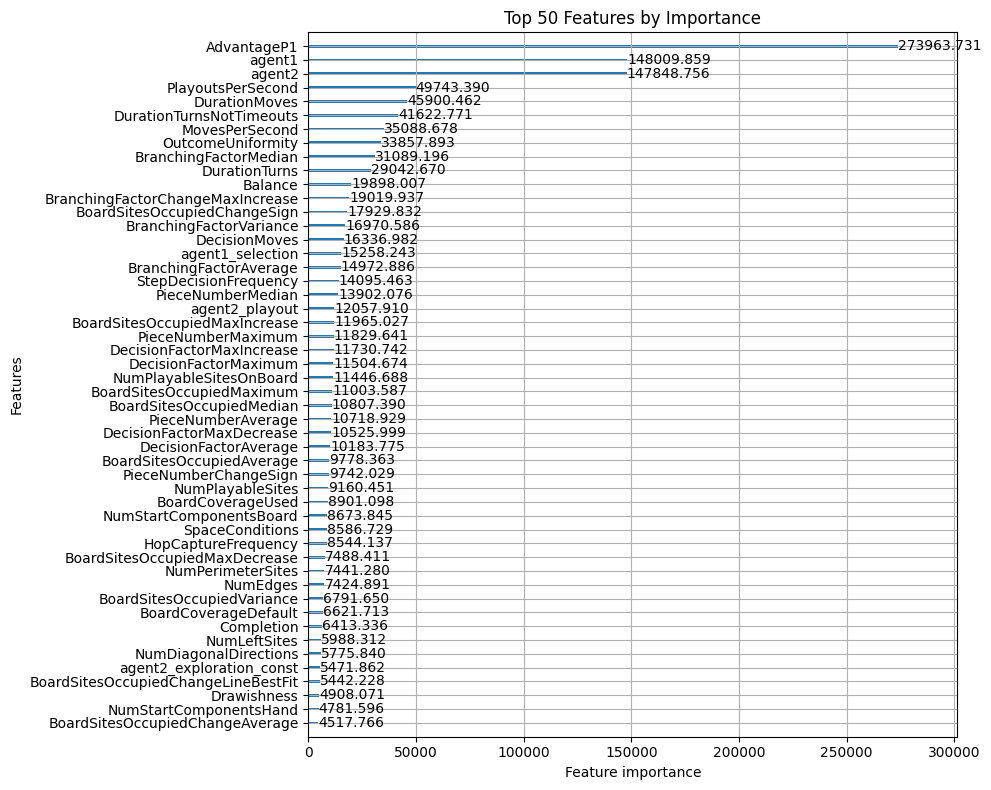

Fold 5 - RMSE: 0.4237518435929712
List of oof scores: [0.4090814555171167, 0.39987774036222845, 0.42441467858348025, 0.4342117205470023, 0.4237518435929712]
Average oof score: 0.4182674877205598


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.503053


[200]	valid_0's rmse: 0.478715


[300]	valid_0's rmse: 0.468206


[400]	valid_0's rmse: 0.461391


[500]	valid_0's rmse: 0.456647


[600]	valid_0's rmse: 0.453328


[700]	valid_0's rmse: 0.450587


[800]	valid_0's rmse: 0.448467


[900]	valid_0's rmse: 0.446295


[1000]	valid_0's rmse: 0.444698


[1100]	valid_0's rmse: 0.443222


[1200]	valid_0's rmse: 0.442043


[1300]	valid_0's rmse: 0.441145


[1400]	valid_0's rmse: 0.44023


[1500]	valid_0's rmse: 0.439422


[1600]	valid_0's rmse: 0.438856


[1700]	valid_0's rmse: 0.438168


[1800]	valid_0's rmse: 0.437446


[1900]	valid_0's rmse: 0.437102


[2000]	valid_0's rmse: 0.43661


[2100]	valid_0's rmse: 0.436089


[2200]	valid_0's rmse: 0.435663


[2300]	valid_0's rmse: 0.435339


[2400]	valid_0's rmse: 0.43498


[2500]	valid_0's rmse: 0.434744


[2600]	valid_0's rmse: 0.434456


[2700]	valid_0's rmse: 0.434215


[2800]	valid_0's rmse: 0.433932


[2900]	valid_0's rmse: 0.43365


[3000]	valid_0's rmse: 0.433353


[3100]	valid_0's rmse: 0.433147


[3200]	valid_0's rmse: 0.433005


[3300]	valid_0's rmse: 0.432863


[3400]	valid_0's rmse: 0.432742


[3500]	valid_0's rmse: 0.43253


[3600]	valid_0's rmse: 0.432366


[3700]	valid_0's rmse: 0.432253


[3800]	valid_0's rmse: 0.432145


[3900]	valid_0's rmse: 0.43199


[4000]	valid_0's rmse: 0.431954


[4100]	valid_0's rmse: 0.431783


[4200]	valid_0's rmse: 0.431707


[4300]	valid_0's rmse: 0.431606


[4400]	valid_0's rmse: 0.431434


[4500]	valid_0's rmse: 0.431191


[4600]	valid_0's rmse: 0.431184


[4700]	valid_0's rmse: 0.43115


[4800]	valid_0's rmse: 0.431195


[4900]	valid_0's rmse: 0.431106


[5000]	valid_0's rmse: 0.430993


[5100]	valid_0's rmse: 0.430859


[5200]	valid_0's rmse: 0.430767


[5300]	valid_0's rmse: 0.430718


[5400]	valid_0's rmse: 0.43067


[5500]	valid_0's rmse: 0.430555


[5600]	valid_0's rmse: 0.430375


[5700]	valid_0's rmse: 0.430293


[5800]	valid_0's rmse: 0.430279


[5900]	valid_0's rmse: 0.430238


[6000]	valid_0's rmse: 0.430227


[6100]	valid_0's rmse: 0.43021


[6200]	valid_0's rmse: 0.430161


[6300]	valid_0's rmse: 0.430161


[6400]	valid_0's rmse: 0.430088


[6500]	valid_0's rmse: 0.430116


[6600]	valid_0's rmse: 0.43007


[6700]	valid_0's rmse: 0.430013


[6800]	valid_0's rmse: 0.42994


[6900]	valid_0's rmse: 0.4299


[7000]	valid_0's rmse: 0.429879


[7100]	valid_0's rmse: 0.42981


[7200]	valid_0's rmse: 0.429764


[7300]	valid_0's rmse: 0.429712


[7400]	valid_0's rmse: 0.429717


[7500]	valid_0's rmse: 0.429669


[7600]	valid_0's rmse: 0.429691


[7700]	valid_0's rmse: 0.429656


[7800]	valid_0's rmse: 0.429667


[7900]	valid_0's rmse: 0.429656


[8000]	valid_0's rmse: 0.429676


[8100]	valid_0's rmse: 0.429636


[8200]	valid_0's rmse: 0.429669


[8300]	valid_0's rmse: 0.429662


[8400]	valid_0's rmse: 0.42967


[8500]	valid_0's rmse: 0.42965


[8600]	valid_0's rmse: 0.429621


[8700]	valid_0's rmse: 0.429596


[8800]	valid_0's rmse: 0.429563


[8900]	valid_0's rmse: 0.429545


[9000]	valid_0's rmse: 0.429541


[9100]	valid_0's rmse: 0.42944


[9200]	valid_0's rmse: 0.429477


[9300]	valid_0's rmse: 0.429419


[9400]	valid_0's rmse: 0.429414


[9500]	valid_0's rmse: 0.429425


[9600]	valid_0's rmse: 0.429357


[9700]	valid_0's rmse: 0.429361


[9800]	valid_0's rmse: 0.429382


[9900]	valid_0's rmse: 0.429384


[10000]	valid_0's rmse: 0.429345


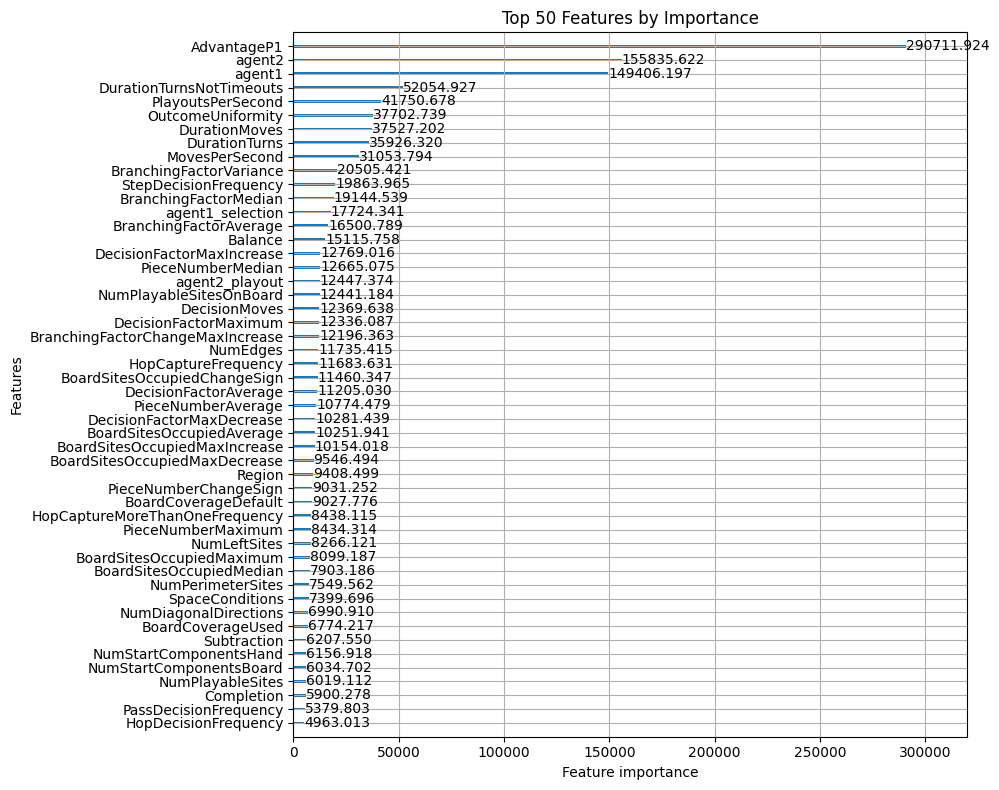

Fold 1 - RMSE: 0.4287828311556081
Fold 2


[100]	valid_0's rmse: 0.506956


[200]	valid_0's rmse: 0.482588


[300]	valid_0's rmse: 0.466643


[400]	valid_0's rmse: 0.459116


[500]	valid_0's rmse: 0.453614


[600]	valid_0's rmse: 0.44926


[700]	valid_0's rmse: 0.446268


[800]	valid_0's rmse: 0.443011


[900]	valid_0's rmse: 0.440324


[1000]	valid_0's rmse: 0.438316


[1100]	valid_0's rmse: 0.436509


[1200]	valid_0's rmse: 0.434702


[1300]	valid_0's rmse: 0.43326


[1400]	valid_0's rmse: 0.431793


[1500]	valid_0's rmse: 0.430693


[1600]	valid_0's rmse: 0.429711


[1700]	valid_0's rmse: 0.428802


[1800]	valid_0's rmse: 0.42794


[1900]	valid_0's rmse: 0.427297


[2000]	valid_0's rmse: 0.426538


[2100]	valid_0's rmse: 0.425996


[2200]	valid_0's rmse: 0.425358


[2300]	valid_0's rmse: 0.424813


[2400]	valid_0's rmse: 0.424183


[2500]	valid_0's rmse: 0.423748


[2600]	valid_0's rmse: 0.423363


[2700]	valid_0's rmse: 0.422866


[2800]	valid_0's rmse: 0.422433


[2900]	valid_0's rmse: 0.422073


[3000]	valid_0's rmse: 0.421629


[3100]	valid_0's rmse: 0.421319


[3200]	valid_0's rmse: 0.421025


[3300]	valid_0's rmse: 0.420598


[3400]	valid_0's rmse: 0.420352


[3500]	valid_0's rmse: 0.420048


[3600]	valid_0's rmse: 0.419744


[3700]	valid_0's rmse: 0.419492


[3800]	valid_0's rmse: 0.41924


[3900]	valid_0's rmse: 0.419092


[4000]	valid_0's rmse: 0.418835


[4100]	valid_0's rmse: 0.4186


[4200]	valid_0's rmse: 0.418558


[4300]	valid_0's rmse: 0.418345


[4400]	valid_0's rmse: 0.418229


[4500]	valid_0's rmse: 0.418071


[4600]	valid_0's rmse: 0.417876


[4700]	valid_0's rmse: 0.417679


[4800]	valid_0's rmse: 0.417536


[4900]	valid_0's rmse: 0.417387


[5000]	valid_0's rmse: 0.417308


[5100]	valid_0's rmse: 0.417178


[5200]	valid_0's rmse: 0.41706


[5300]	valid_0's rmse: 0.416931


[5400]	valid_0's rmse: 0.416839


[5500]	valid_0's rmse: 0.416774


[5600]	valid_0's rmse: 0.416634


[5700]	valid_0's rmse: 0.416556


[5800]	valid_0's rmse: 0.416462


[5900]	valid_0's rmse: 0.41638


[6000]	valid_0's rmse: 0.416343


[6100]	valid_0's rmse: 0.416242


[6200]	valid_0's rmse: 0.416227


[6300]	valid_0's rmse: 0.416079


[6400]	valid_0's rmse: 0.415948


[6500]	valid_0's rmse: 0.415902


[6600]	valid_0's rmse: 0.41582


[6700]	valid_0's rmse: 0.415749


[6800]	valid_0's rmse: 0.415653


[6900]	valid_0's rmse: 0.415547


[7000]	valid_0's rmse: 0.415525


[7100]	valid_0's rmse: 0.415479


[7200]	valid_0's rmse: 0.415472


[7300]	valid_0's rmse: 0.4154


[7400]	valid_0's rmse: 0.415368


[7500]	valid_0's rmse: 0.415313


[7600]	valid_0's rmse: 0.41524


[7700]	valid_0's rmse: 0.415247


[7800]	valid_0's rmse: 0.415238


[7900]	valid_0's rmse: 0.41522


[8000]	valid_0's rmse: 0.415221


[8100]	valid_0's rmse: 0.415199


[8200]	valid_0's rmse: 0.415108


[8300]	valid_0's rmse: 0.415058


[8400]	valid_0's rmse: 0.414979


[8500]	valid_0's rmse: 0.414896


[8600]	valid_0's rmse: 0.414866


[8700]	valid_0's rmse: 0.414775


[8800]	valid_0's rmse: 0.414712


[8900]	valid_0's rmse: 0.414698


[9000]	valid_0's rmse: 0.414665


[9100]	valid_0's rmse: 0.414618


[9200]	valid_0's rmse: 0.414617


[9300]	valid_0's rmse: 0.414563


[9400]	valid_0's rmse: 0.414514


[9500]	valid_0's rmse: 0.414472


[9600]	valid_0's rmse: 0.414438


[9700]	valid_0's rmse: 0.414431


[9800]	valid_0's rmse: 0.41442


[9900]	valid_0's rmse: 0.414419


[10000]	valid_0's rmse: 0.414452


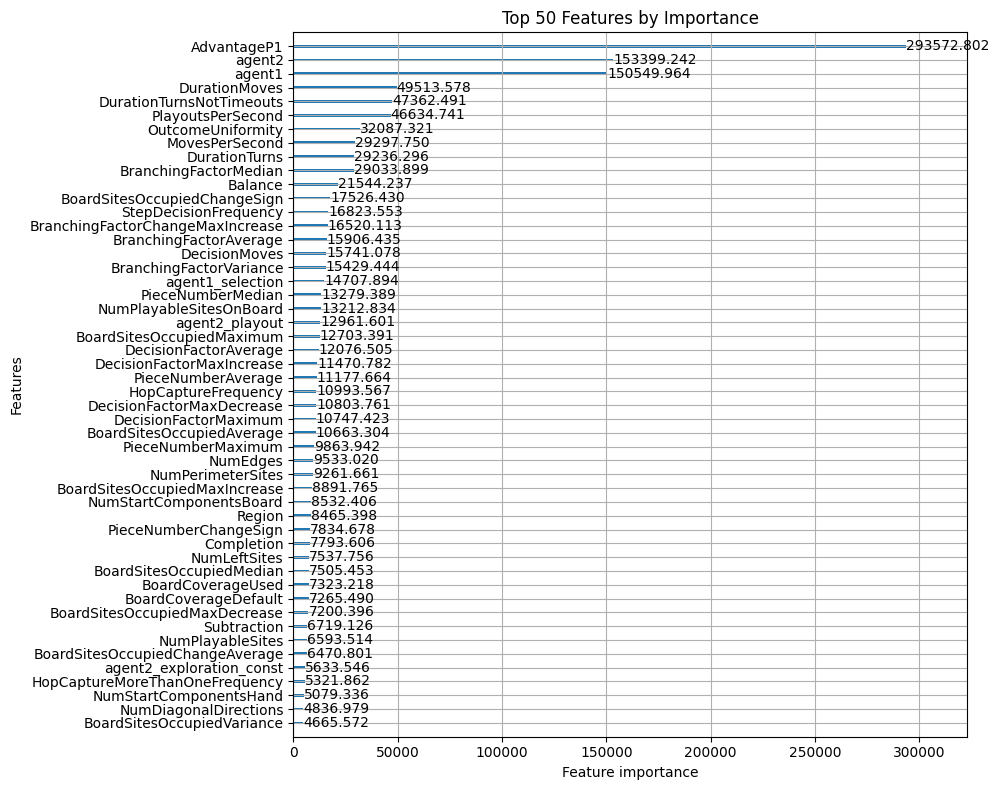

Fold 2 - RMSE: 0.4139534850318475
Fold 3


[100]	valid_0's rmse: 0.497688


[200]	valid_0's rmse: 0.475677


[300]	valid_0's rmse: 0.465094


[400]	valid_0's rmse: 0.458362


[500]	valid_0's rmse: 0.453412


[600]	valid_0's rmse: 0.450207


[700]	valid_0's rmse: 0.447699


[800]	valid_0's rmse: 0.445531


[900]	valid_0's rmse: 0.443624


[1000]	valid_0's rmse: 0.442379


[1100]	valid_0's rmse: 0.440984


[1200]	valid_0's rmse: 0.439759


[1300]	valid_0's rmse: 0.438951


[1400]	valid_0's rmse: 0.437837


[1500]	valid_0's rmse: 0.437019


[1600]	valid_0's rmse: 0.436306


[1700]	valid_0's rmse: 0.435696


[1800]	valid_0's rmse: 0.435013


[1900]	valid_0's rmse: 0.434516


[2000]	valid_0's rmse: 0.434126


[2100]	valid_0's rmse: 0.433754


[2200]	valid_0's rmse: 0.433268


[2300]	valid_0's rmse: 0.432901


[2400]	valid_0's rmse: 0.432603


[2500]	valid_0's rmse: 0.432138


[2600]	valid_0's rmse: 0.431799


[2700]	valid_0's rmse: 0.431597


[2800]	valid_0's rmse: 0.431335


[2900]	valid_0's rmse: 0.431063


[3000]	valid_0's rmse: 0.430745


[3100]	valid_0's rmse: 0.430459


[3200]	valid_0's rmse: 0.430272


[3300]	valid_0's rmse: 0.430038


[3400]	valid_0's rmse: 0.429856


[3500]	valid_0's rmse: 0.429643


[3600]	valid_0's rmse: 0.429495


[3700]	valid_0's rmse: 0.429343


[3800]	valid_0's rmse: 0.429205


[3900]	valid_0's rmse: 0.429107


[4000]	valid_0's rmse: 0.429017


[4100]	valid_0's rmse: 0.428976


[4200]	valid_0's rmse: 0.428874


[4300]	valid_0's rmse: 0.428727


[4400]	valid_0's rmse: 0.428505


[4500]	valid_0's rmse: 0.428352


[4600]	valid_0's rmse: 0.428219


[4700]	valid_0's rmse: 0.428223


[4800]	valid_0's rmse: 0.428202


[4900]	valid_0's rmse: 0.42806


[5000]	valid_0's rmse: 0.427917


[5100]	valid_0's rmse: 0.427858


[5200]	valid_0's rmse: 0.427808


[5300]	valid_0's rmse: 0.42767


[5400]	valid_0's rmse: 0.42761


[5500]	valid_0's rmse: 0.427559


[5600]	valid_0's rmse: 0.427472


[5700]	valid_0's rmse: 0.4274


[5800]	valid_0's rmse: 0.427285


[5900]	valid_0's rmse: 0.427243


[6000]	valid_0's rmse: 0.42718


[6100]	valid_0's rmse: 0.427181


[6200]	valid_0's rmse: 0.427158


[6300]	valid_0's rmse: 0.427147


[6400]	valid_0's rmse: 0.427084


[6500]	valid_0's rmse: 0.427088


[6600]	valid_0's rmse: 0.426994


[6700]	valid_0's rmse: 0.426986


[6800]	valid_0's rmse: 0.426931


[6900]	valid_0's rmse: 0.426881


[7000]	valid_0's rmse: 0.4268


[7100]	valid_0's rmse: 0.426704


[7200]	valid_0's rmse: 0.426674


[7300]	valid_0's rmse: 0.426664


[7400]	valid_0's rmse: 0.426656


[7500]	valid_0's rmse: 0.426696


[7600]	valid_0's rmse: 0.426638


[7700]	valid_0's rmse: 0.42662


[7800]	valid_0's rmse: 0.4266


[7900]	valid_0's rmse: 0.426574


[8000]	valid_0's rmse: 0.426544


[8100]	valid_0's rmse: 0.426514


[8200]	valid_0's rmse: 0.426425


[8300]	valid_0's rmse: 0.4264


[8400]	valid_0's rmse: 0.426425


[8500]	valid_0's rmse: 0.426426


[8600]	valid_0's rmse: 0.426398


[8700]	valid_0's rmse: 0.426398


[8800]	valid_0's rmse: 0.426467


[8900]	valid_0's rmse: 0.426392


[9000]	valid_0's rmse: 0.426389


[9100]	valid_0's rmse: 0.426365


[9200]	valid_0's rmse: 0.426343


[9300]	valid_0's rmse: 0.42628


[9400]	valid_0's rmse: 0.426212


[9500]	valid_0's rmse: 0.42621


[9600]	valid_0's rmse: 0.4262


[9700]	valid_0's rmse: 0.426206


[9800]	valid_0's rmse: 0.426221


[9900]	valid_0's rmse: 0.426233


[10000]	valid_0's rmse: 0.426253


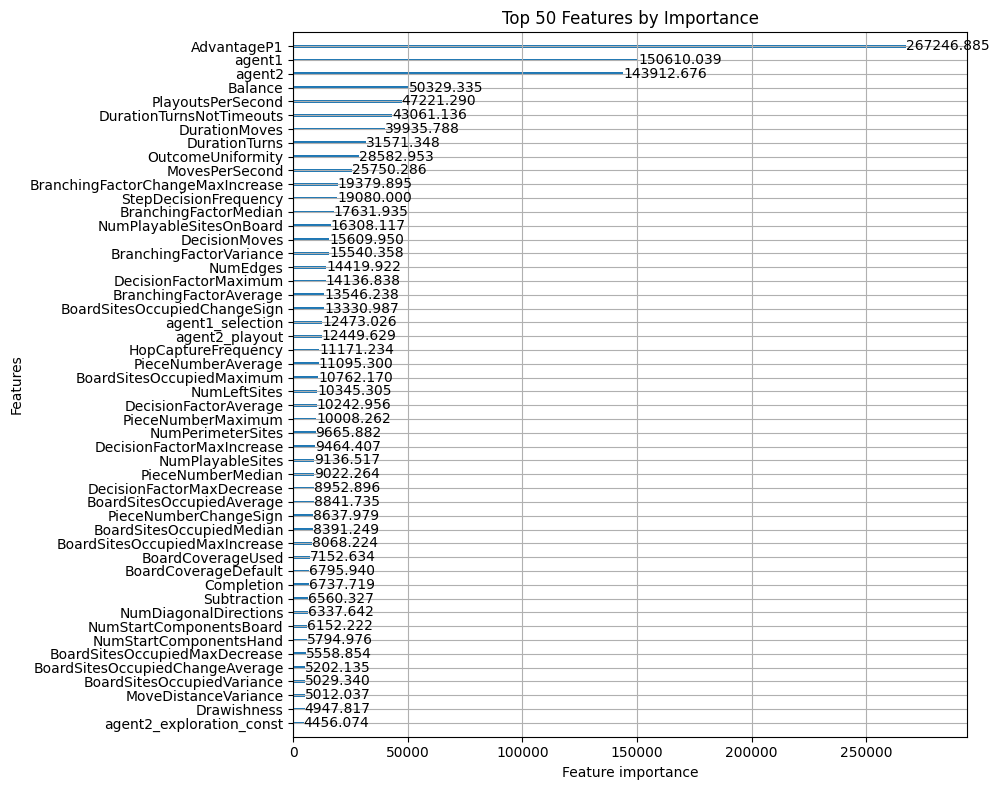

Fold 3 - RMSE: 0.42585812220143165
Fold 4


[100]	valid_0's rmse: 0.490552


[200]	valid_0's rmse: 0.464166


[300]	valid_0's rmse: 0.452371


[400]	valid_0's rmse: 0.446371


[500]	valid_0's rmse: 0.441939


[600]	valid_0's rmse: 0.438556


[700]	valid_0's rmse: 0.436489


[800]	valid_0's rmse: 0.434232


[900]	valid_0's rmse: 0.432329


[1000]	valid_0's rmse: 0.430695


[1100]	valid_0's rmse: 0.429459


[1200]	valid_0's rmse: 0.428262


[1300]	valid_0's rmse: 0.427417


[1400]	valid_0's rmse: 0.426668


[1500]	valid_0's rmse: 0.425767


[1600]	valid_0's rmse: 0.424991


[1700]	valid_0's rmse: 0.42463


[1800]	valid_0's rmse: 0.424144


[1900]	valid_0's rmse: 0.423776


[2000]	valid_0's rmse: 0.423372


[2100]	valid_0's rmse: 0.42301


[2200]	valid_0's rmse: 0.422771


[2300]	valid_0's rmse: 0.422367


[2400]	valid_0's rmse: 0.422001


[2500]	valid_0's rmse: 0.42178


[2600]	valid_0's rmse: 0.42152


[2700]	valid_0's rmse: 0.421241


[2800]	valid_0's rmse: 0.421002


[2900]	valid_0's rmse: 0.420826


[3000]	valid_0's rmse: 0.4206


[3100]	valid_0's rmse: 0.42051


[3200]	valid_0's rmse: 0.420285


[3300]	valid_0's rmse: 0.420204


[3400]	valid_0's rmse: 0.420078


[3500]	valid_0's rmse: 0.419911


[3600]	valid_0's rmse: 0.419809


[3700]	valid_0's rmse: 0.419699


[3800]	valid_0's rmse: 0.419585


[3900]	valid_0's rmse: 0.41945


[4000]	valid_0's rmse: 0.419321


[4100]	valid_0's rmse: 0.419161


[4200]	valid_0's rmse: 0.419092


[4300]	valid_0's rmse: 0.419049


[4400]	valid_0's rmse: 0.418991


[4500]	valid_0's rmse: 0.418946


[4600]	valid_0's rmse: 0.418854


[4700]	valid_0's rmse: 0.418695


[4800]	valid_0's rmse: 0.418666


[4900]	valid_0's rmse: 0.41861


[5000]	valid_0's rmse: 0.41855


[5100]	valid_0's rmse: 0.4185


[5200]	valid_0's rmse: 0.418486


[5300]	valid_0's rmse: 0.418457


[5400]	valid_0's rmse: 0.418325


[5500]	valid_0's rmse: 0.418241


[5600]	valid_0's rmse: 0.418177


[5700]	valid_0's rmse: 0.418149


[5800]	valid_0's rmse: 0.418065


[5900]	valid_0's rmse: 0.417996


[6000]	valid_0's rmse: 0.417948


[6100]	valid_0's rmse: 0.41784


[6200]	valid_0's rmse: 0.41776


[6300]	valid_0's rmse: 0.417683


[6400]	valid_0's rmse: 0.417622


[6500]	valid_0's rmse: 0.417632


[6600]	valid_0's rmse: 0.417651


[6700]	valid_0's rmse: 0.417519


[6800]	valid_0's rmse: 0.417497


[6900]	valid_0's rmse: 0.417432


[7000]	valid_0's rmse: 0.417382


[7100]	valid_0's rmse: 0.417389


[7200]	valid_0's rmse: 0.417367


[7300]	valid_0's rmse: 0.417404


[7400]	valid_0's rmse: 0.417317


[7500]	valid_0's rmse: 0.417287


[7600]	valid_0's rmse: 0.417249


[7700]	valid_0's rmse: 0.417202


[7800]	valid_0's rmse: 0.417172


[7900]	valid_0's rmse: 0.417185


[8000]	valid_0's rmse: 0.41714


[8100]	valid_0's rmse: 0.417104


[8200]	valid_0's rmse: 0.417107


[8300]	valid_0's rmse: 0.417074


[8400]	valid_0's rmse: 0.41703


[8500]	valid_0's rmse: 0.416968


[8600]	valid_0's rmse: 0.416928


[8700]	valid_0's rmse: 0.41691


[8800]	valid_0's rmse: 0.416899


[8900]	valid_0's rmse: 0.41687


[9000]	valid_0's rmse: 0.416856


[9100]	valid_0's rmse: 0.416812


[9200]	valid_0's rmse: 0.41678


[9300]	valid_0's rmse: 0.416758


[9400]	valid_0's rmse: 0.416731


[9500]	valid_0's rmse: 0.416685


[9600]	valid_0's rmse: 0.416613


[9700]	valid_0's rmse: 0.416533


[9800]	valid_0's rmse: 0.416526


[9900]	valid_0's rmse: 0.416493


[10000]	valid_0's rmse: 0.416522


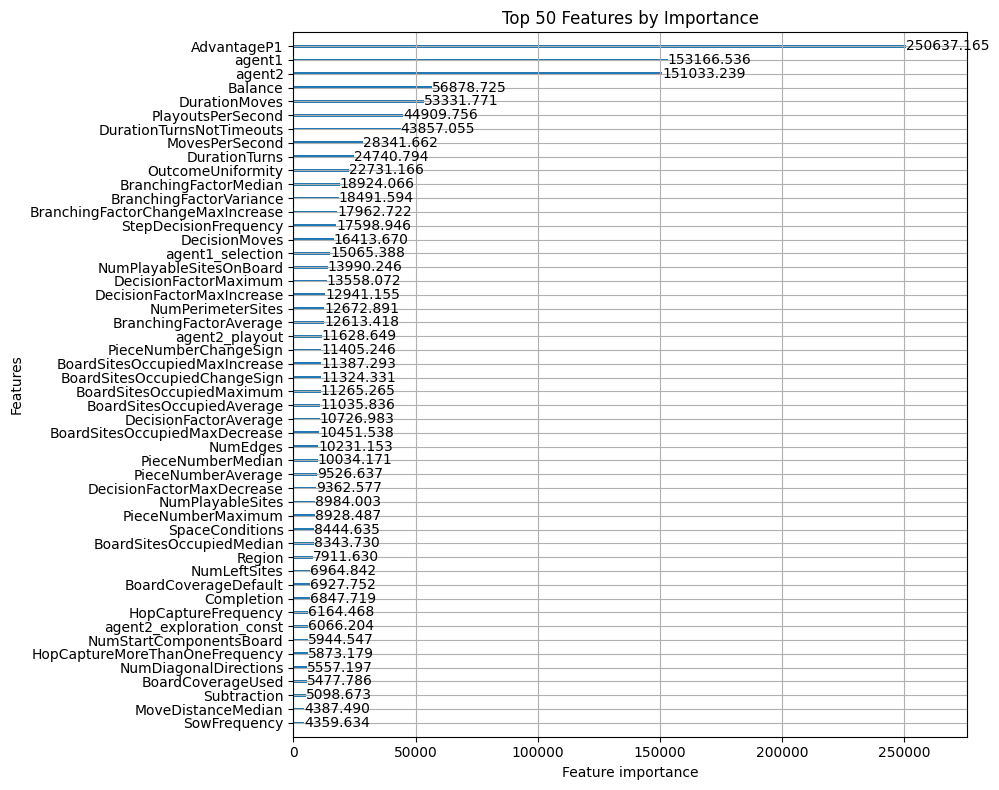

Fold 4 - RMSE: 0.41566530134297125
Fold 5


[100]	valid_0's rmse: 0.507723


[200]	valid_0's rmse: 0.484898


[300]	valid_0's rmse: 0.471903


[400]	valid_0's rmse: 0.463091


[500]	valid_0's rmse: 0.457514


[600]	valid_0's rmse: 0.45255


[700]	valid_0's rmse: 0.44845


[800]	valid_0's rmse: 0.445498


[900]	valid_0's rmse: 0.443334


[1000]	valid_0's rmse: 0.441309


[1100]	valid_0's rmse: 0.439668


[1200]	valid_0's rmse: 0.438136


[1300]	valid_0's rmse: 0.436838


[1400]	valid_0's rmse: 0.435526


[1500]	valid_0's rmse: 0.434438


[1600]	valid_0's rmse: 0.433447


[1700]	valid_0's rmse: 0.43258


[1800]	valid_0's rmse: 0.432001


[1900]	valid_0's rmse: 0.431158


[2000]	valid_0's rmse: 0.430482


[2100]	valid_0's rmse: 0.429749


[2200]	valid_0's rmse: 0.42925


[2300]	valid_0's rmse: 0.428632


[2400]	valid_0's rmse: 0.428066


[2500]	valid_0's rmse: 0.427573


[2600]	valid_0's rmse: 0.427264


[2700]	valid_0's rmse: 0.426875


[2800]	valid_0's rmse: 0.426503


[2900]	valid_0's rmse: 0.426175


[3000]	valid_0's rmse: 0.42586


[3100]	valid_0's rmse: 0.425562


[3200]	valid_0's rmse: 0.425326


[3300]	valid_0's rmse: 0.425054


[3400]	valid_0's rmse: 0.424829


[3500]	valid_0's rmse: 0.424681


[3600]	valid_0's rmse: 0.424516


[3700]	valid_0's rmse: 0.424335


[3800]	valid_0's rmse: 0.424085


[3900]	valid_0's rmse: 0.423896


[4000]	valid_0's rmse: 0.423676


[4100]	valid_0's rmse: 0.423582


[4200]	valid_0's rmse: 0.423367


[4300]	valid_0's rmse: 0.423214


[4400]	valid_0's rmse: 0.423026


[4500]	valid_0's rmse: 0.422832


[4600]	valid_0's rmse: 0.422697


[4700]	valid_0's rmse: 0.422509


[4800]	valid_0's rmse: 0.422349


[4900]	valid_0's rmse: 0.422112


[5000]	valid_0's rmse: 0.422045


[5100]	valid_0's rmse: 0.421812


[5200]	valid_0's rmse: 0.421706


[5300]	valid_0's rmse: 0.421565


[5400]	valid_0's rmse: 0.421481


[5500]	valid_0's rmse: 0.421366


[5600]	valid_0's rmse: 0.421314


[5700]	valid_0's rmse: 0.421199


[5800]	valid_0's rmse: 0.421058


[5900]	valid_0's rmse: 0.420969


[6000]	valid_0's rmse: 0.42087


[6100]	valid_0's rmse: 0.420752


[6200]	valid_0's rmse: 0.420647


[6300]	valid_0's rmse: 0.420534


[6400]	valid_0's rmse: 0.42046


[6500]	valid_0's rmse: 0.420368


[6600]	valid_0's rmse: 0.420293


[6700]	valid_0's rmse: 0.420179


[6800]	valid_0's rmse: 0.42008


[6900]	valid_0's rmse: 0.420046


[7000]	valid_0's rmse: 0.419996


[7100]	valid_0's rmse: 0.419927


[7200]	valid_0's rmse: 0.419874


[7300]	valid_0's rmse: 0.419869


[7400]	valid_0's rmse: 0.419841


[7500]	valid_0's rmse: 0.41983


[7600]	valid_0's rmse: 0.419792


[7700]	valid_0's rmse: 0.419758


[7800]	valid_0's rmse: 0.419633


[7900]	valid_0's rmse: 0.419611


[8000]	valid_0's rmse: 0.41949


[8100]	valid_0's rmse: 0.419488


[8200]	valid_0's rmse: 0.419392


[8300]	valid_0's rmse: 0.419337


[8400]	valid_0's rmse: 0.419353


[8500]	valid_0's rmse: 0.419302


[8600]	valid_0's rmse: 0.419291


[8700]	valid_0's rmse: 0.419219


[8800]	valid_0's rmse: 0.419186


[8900]	valid_0's rmse: 0.419181


[9000]	valid_0's rmse: 0.419143


[9100]	valid_0's rmse: 0.419098


[9200]	valid_0's rmse: 0.419039


[9300]	valid_0's rmse: 0.419019


[9400]	valid_0's rmse: 0.418946


[9500]	valid_0's rmse: 0.418917


[9600]	valid_0's rmse: 0.418904


[9700]	valid_0's rmse: 0.418881


[9800]	valid_0's rmse: 0.418857


[9900]	valid_0's rmse: 0.418776


[10000]	valid_0's rmse: 0.418785


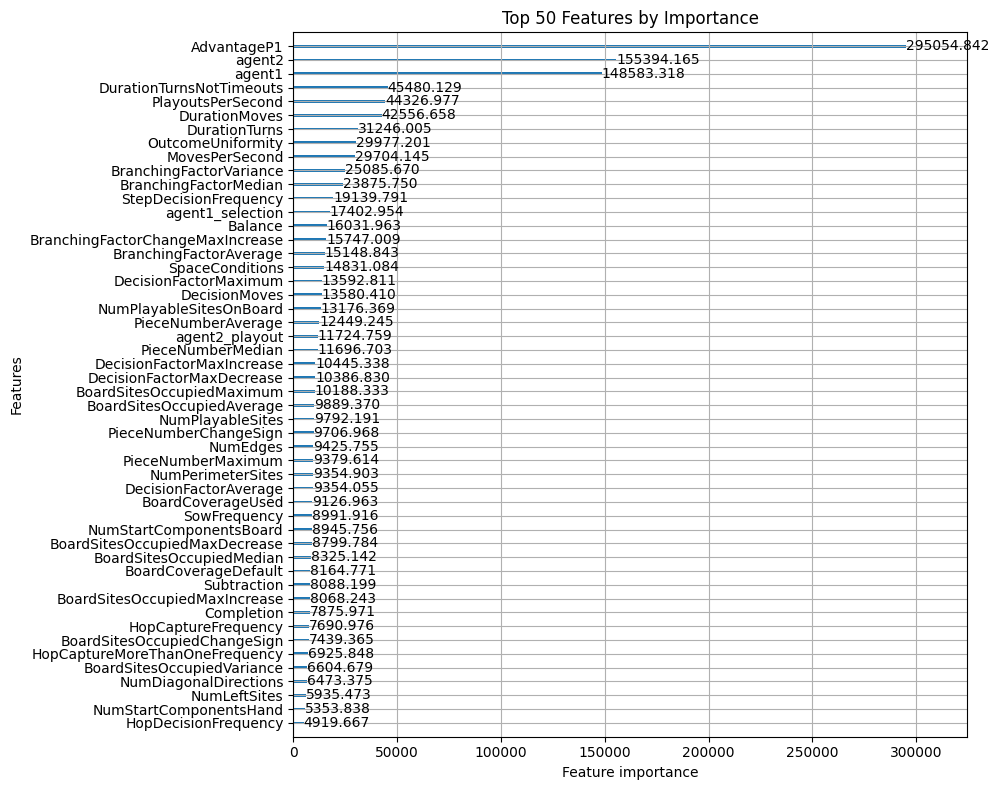

Fold 5 - RMSE: 0.41814174414227107
List of oof scores: [0.4287828311556081, 0.4139534850318475, 0.42585812220143165, 0.41566530134297125, 0.41814174414227107]
Average oof score: 0.4204802967748259


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4257
Score: 0.4430
Score: 0.4273
Score: 0.4312
Score: 0.4043
Average CV1 Score: 0.4263

CV2 OOF Scores:
Score: 0.4091
Score: 0.3999
Score: 0.4244
Score: 0.4342
Score: 0.4238
Average CV2 Score: 0.4183

CV3 OOF Scores:
Score: 0.4288
Score: 0.4140
Score: 0.4259
Score: 0.4157
Score: 0.4181
Average CV3 Score: 0.4205


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

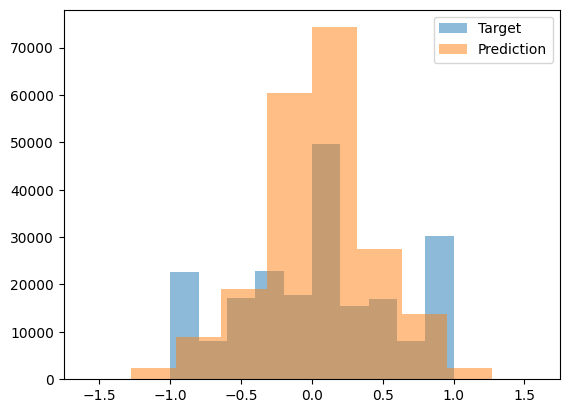

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.13214        │
│ 233235 ┆ -0.161648      │
│ 233236 ┆ -0.061509      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***